In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [41]:
import os
folder_path = '/content/drive/My Drive/https://drive.google.com/drive/folders/1ImvgLAN_SDJ5RrkuuMnCUd3-za_OZEvB'

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
import timm
import random
import time
from collections import OrderedDict
from torch.cuda import amp
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.optim.optimizer
from torchvision import transforms as T
import matplotlib.pyplot as plt
from torchvision.io import read_image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sns
from tqdm import tqdm
import concurrent.futures
from torch.utils.data import random_split
from sklearn.metrics import classification_report, f1_score

print(torch.__version__)

2.5.1+cu121


In [9]:
base = '/content/drive/My Drive'
folder_name = 'aptos2019-blindness-detection'
folder_path = os.path.join(base, folder_name)

if os.path.exists(folder_path):
    print(f"Contents of {folder_name}:", os.listdir(folder_path))
else:
    print(f"Folder {folder_name} does not exist!")

Contents of aptos2019-blindness-detection: ['test.csv', 'sample_submission.csv', 'train.csv', 'test_images', 'train_images', 'Beforepreprocessing', 'train.gsheet', 'Beforepreprocessing.png']


In [10]:
testcsv = 'test.csv'
traincsv = 'train.csv'
file1_path = os.path.join(folder_path, testcsv)
file2_path = os.path.join(folder_path, traincsv)

In [11]:
test = pd.read_csv(file1_path)
train = pd.read_csv(file2_path)

In [12]:
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

<ipython-input-13-5a39dd9eea6e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="diagnosis", data=train, palette="GnBu_d")


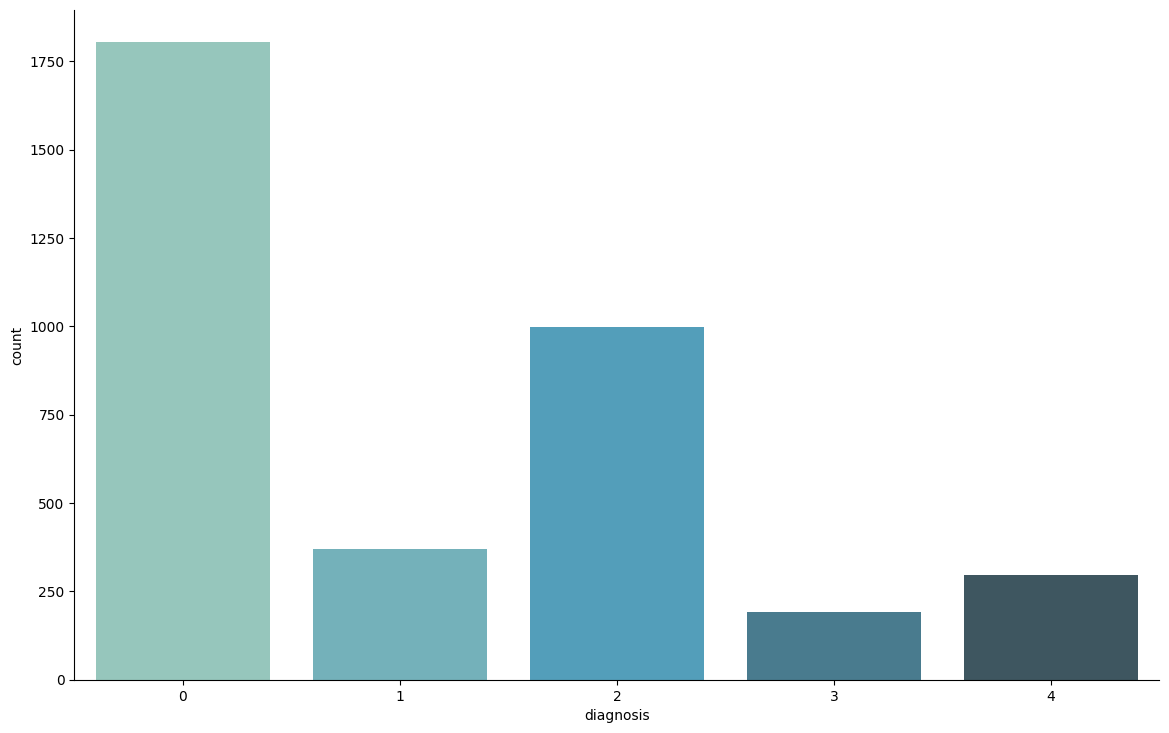

In [13]:
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x="diagnosis", data=train, palette="GnBu_d")
sns.despine()
plt.show()

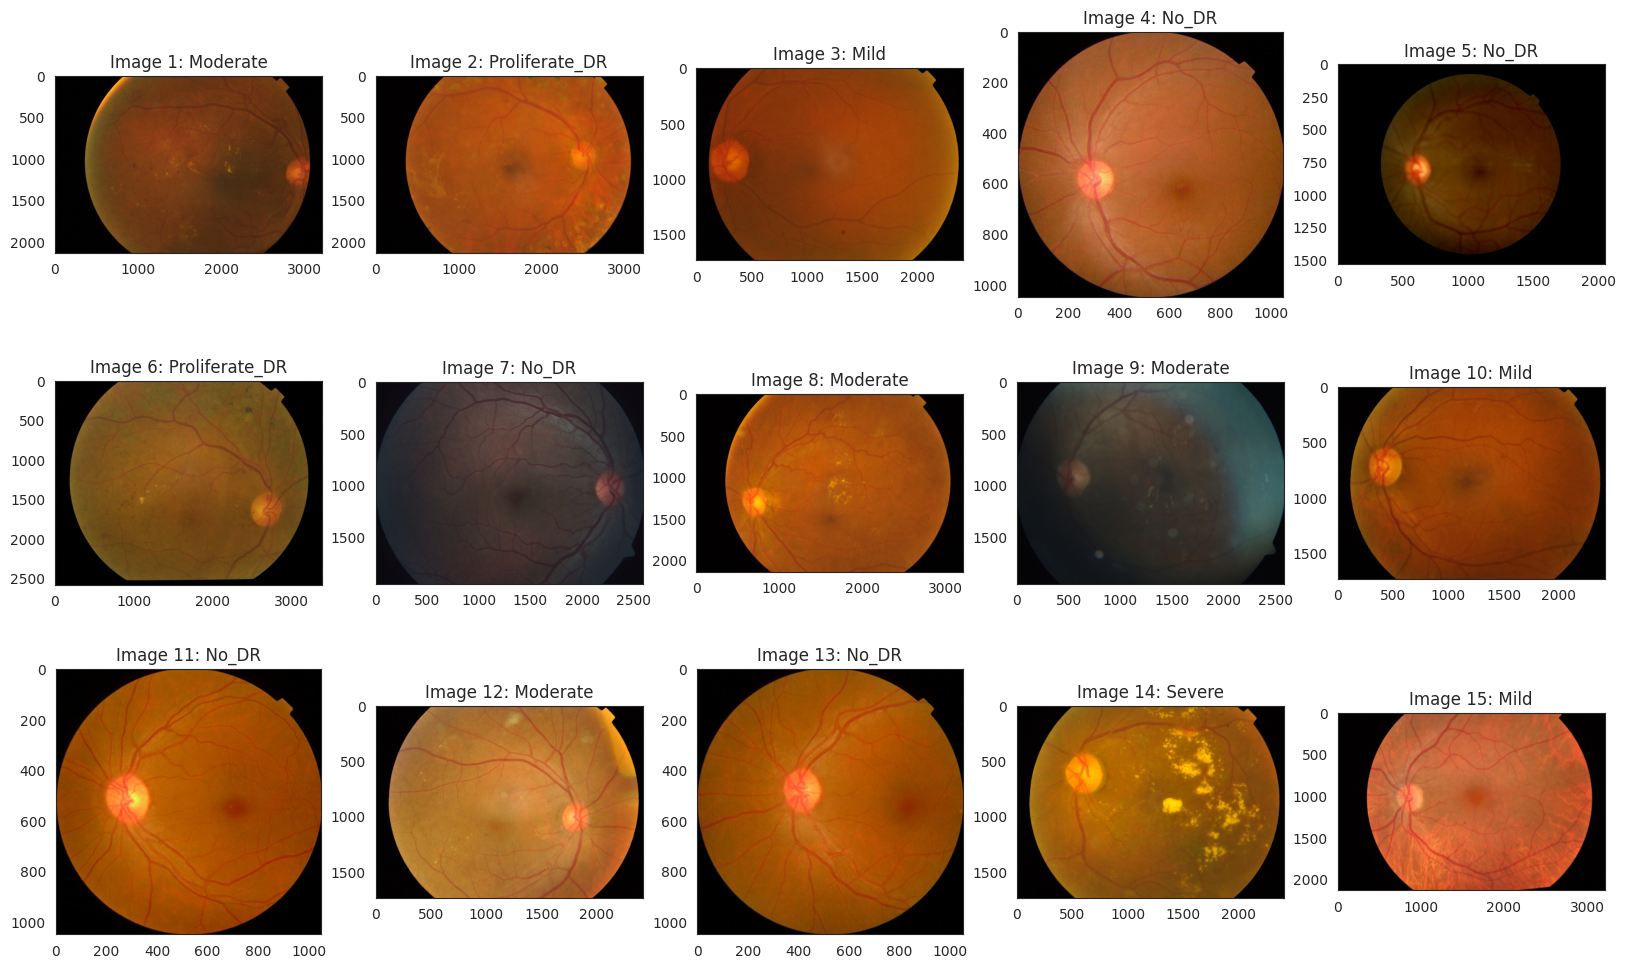

In [40]:
sns.set_style("white")
level_to_category = {
    0: "No_DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}
count = 1
plt.figure(figsize=[20, 20])

for img_name in train['id_code'][:15]:
    img = cv2.imread(f"/content/drive/My Drive/aptos2019-blindness-detection/train_images/{img_name}.png")[..., [2, 1, 0]]
    label = train[train['id_code'] == img_name]['diagnosis'].values[0]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title(f"Image {count}: {level_to_category[label]}")
    count += 1
plt.savefig('/content/drive/My Drive/aptos2019-blindness-detection/Beforepreprocessing.png')
plt.show()

In [39]:
def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol

        check_shape = img[:,:,0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:
            return img
        else:
            img1 = img[:,:,0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:,:,1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:,:,2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img

In [53]:
input_dir = '/content/drive/My Drive/aptos2019-blindness-detection/train_images/'
output_dir = '/content/drive/My Drive/aptos2019-blindness-detection/processed_images/'
os.makedirs(output_dir, exist_ok=True)
csv_path = '/content/drive/My Drive/aptos2019-blindness-detection/train.csv'
df = pd.read_csv(csv_path)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
def process_image(row):
    sample_image_id = row['id_code']
    sample_image_file = sample_image_id + '.png'
    sample_image_path = os.path.join(input_dir, sample_image_file)

    if os.path.exists(sample_image_path):
        image = cv2.imread(sample_image_path)
        image_cropped = crop_image_from_gray(image)
        image_resized = cv2.resize(image_cropped, (256, 256))
        blue, green, red = cv2.split(image_resized)
        blue_clahe = clahe.apply(blue)
        green_clahe = clahe.apply(green)
        red_clahe = clahe.apply(red)
        result_image = cv2.merge([blue_clahe, green_clahe, red_clahe])
        output_path = os.path.join(output_dir, sample_image_file)
        cv2.imwrite(output_path, result_image)
with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    list(tqdm(executor.map(process_image, [row for _, row in df.iterrows()]), total=df.shape[0], desc="Processing images", unit="image"))

print("Processing complete for all images.")

Processing images: 100%|██████████| 3662/3662 [11:22<00:00,  5.36image/s]

Processing complete for all images.


In [56]:
missing_files = []
for img_name in train['id_code']:
    img_path = f"/content/drive/My Drive/aptos2019-blindness-detection/processed_images/{img_name}.png"
    if not os.path.exists(img_path):
        missing_files.append(img_name)

print(f"Missing files ({len(missing_files)}): {missing_files}")


Missing files (0): []


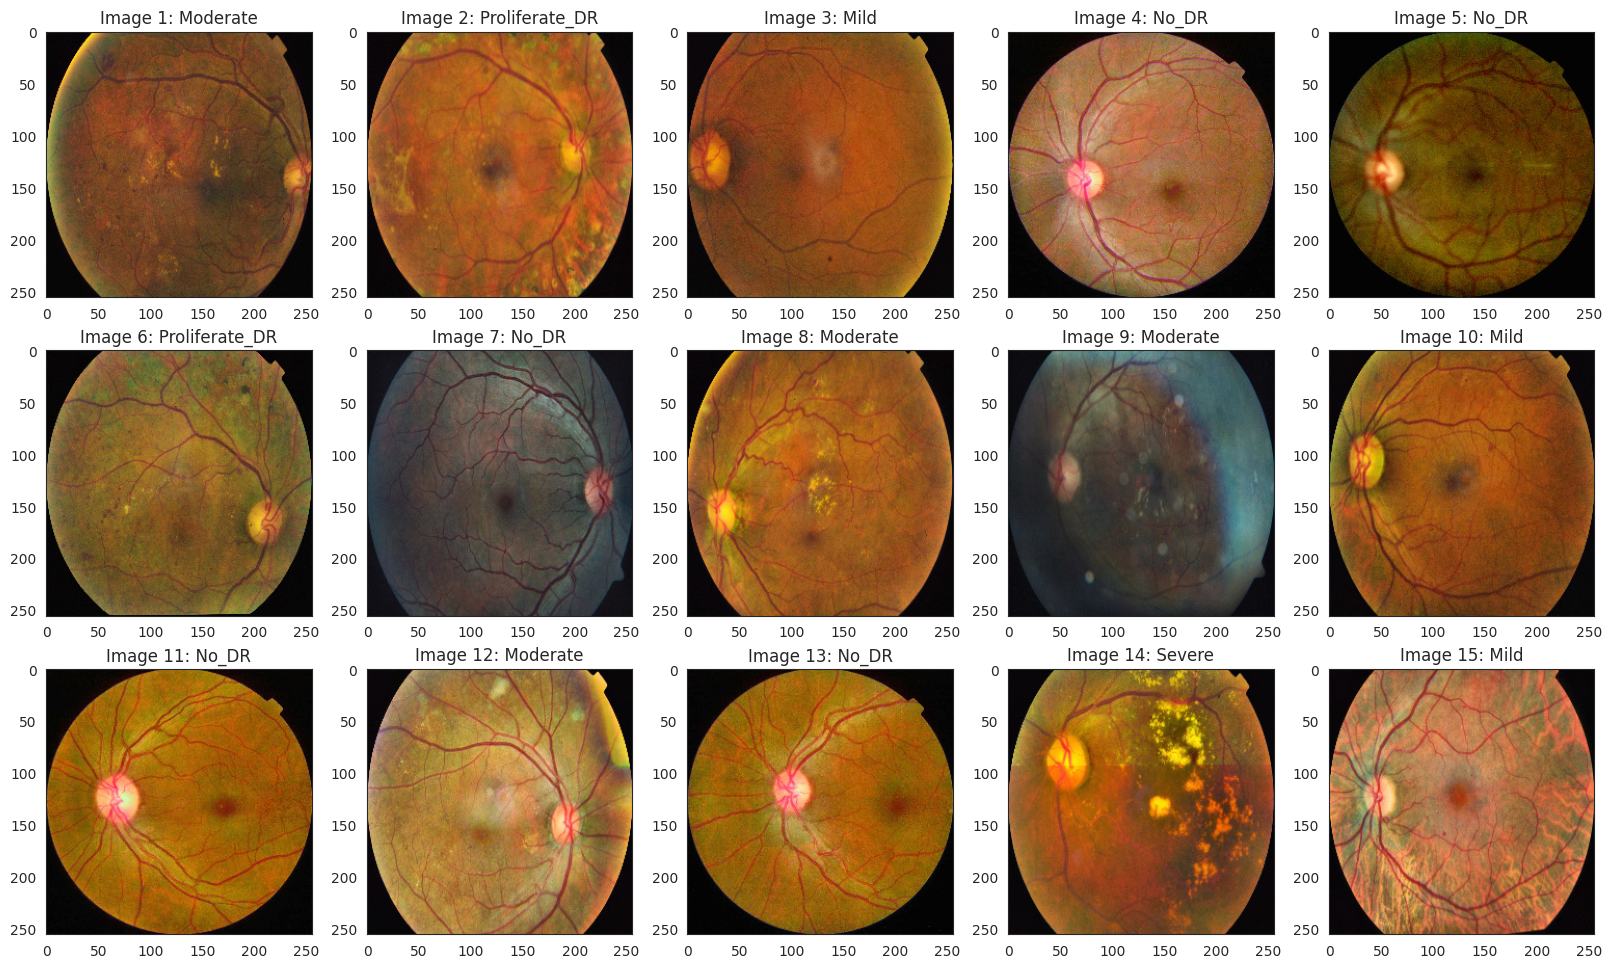

In [60]:
sns.set_style("white")
level_to_category = {
    0: "No_DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}
count = 1
plt.figure(figsize=[20, 20])

for img_name in train['id_code'][:15]:
    img = cv2.imread(f"/content/drive/My Drive/aptos2019-blindness-detection/processed_images/{img_name}.png")[..., [2, 1, 0]]
    label = train[train['id_code'] == img_name]['diagnosis'].values[0]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title(f"Image {count}: {level_to_category[label]}")  # Display the class label
    count += 1
plt.show()

In [58]:
DATA_DIR = "/content/drive/My Drive/aptos2019-blindness-detection/processed_images"
TRAIN_DIR = "/content/drive/My Drive/aptos2019-blindness-detection/processed_images"
CSV_PATH = "/content/drive/My Drive/aptos2019-blindness-detection/train.csv"
MODEL_PATH = "./content/drive/My Drive/"
LEARNING_RATE = 1e-4
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TRAIN_SPLIT = 0.8
NUM_WORKERS = 2
USE_AMP = True
EPOCHS=25

In [59]:
class RetinopathyDataset(Dataset):
    def __init__(self, image_dir, csv_file, transforms=None):
        self.data = pd.read_csv(csv_file)
        self.transforms = transforms
        self.image_dir = image_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.data.loc[idx, 'id_code'] + '.png')

        tensor_image = read_image(img_name)
        label = torch.tensor(self.data.loc[idx, 'diagnosis'], dtype=torch.long)

        if self.transforms is not None:
            tensor_image = self.transforms(tensor_image)

        return (tensor_image, label)

In [20]:
train_trasforms_DeiT_base_patch16= T.Compose([
    T.ConvertImageDtype(torch.float32),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = RetinopathyDataset(TRAIN_DIR, CSV_PATH, transforms=train_trasforms_DeiT_base_patch16)

train_size = int(TRAIN_SPLIT * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(full_dataset, batch_size=TRAIN_BATCH_SIZE,
                          shuffle=False, num_workers=NUM_WORKERS, drop_last=True, pin_memory=False)

val_loader = DataLoader(val_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, drop_last=True, pin_memory=False)

In [21]:
@torch.no_grad()
def accuracy(output, target):
    with torch.no_grad():
        _, predicted = output.max(1)
        correct = predicted.eq(target).sum().item()
        total = target.size(0)
        accuracy = 100.0 * correct / total

    return accuracy


def set_debug_apis(state: bool = False):
    torch.autograd.profiler.profile(enabled=state)
    torch.autograd.profiler.emit_nvtx(enabled=state)
    torch.autograd.set_detect_anomaly(mode=state)


def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print("Size (MB):", os.path.getsize("temp.p") / 1e6)
    os.remove("temp.p")



In [22]:
print(torch.cuda.is_available())

True


In [23]:
def train_step(model: torch.nn.Module, train_loader, criterion, device: str, optimizer, scheduler=None, num_batches: int = None, log_interval: int = 100, scaler=None):
    model = model.to(device)
    model.train()

    start_train_step = time.time()
    metrics = OrderedDict()

    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    with tqdm(train_loader, desc="Training", unit="batch") as pbar:
        for batch_idx, (inputs, target) in enumerate(pbar):
            inputs = inputs.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    output = model(inputs)
                    loss = criterion(output, target)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                output = model(inputs)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
            if scheduler is not None:
                scheduler.step()
            total_loss += loss.item() * inputs.size(0)
            _, predicted = output.max(1)
            correct_predictions += predicted.eq(target).sum().item()
            total_samples += inputs.size(0)
            pbar.set_postfix({
                "Loss": f"{total_loss / total_samples:.4f}",
                "Accuracy": f"{100.0 * correct_predictions / total_samples:.2f}%"
            })
            if num_batches is not None and batch_idx + 1 >= num_batches:
                break
    end_train_step = time.time()
    metrics["loss"] = total_loss / total_samples
    metrics["accuracy"] = 100.0 * correct_predictions / total_samples
    print(f"\nEpoch Summary: Time taken for train step = {end_train_step - start_train_step:.2f} sec")
    print(f"Training loss = {metrics['loss']:.4f}, Training accuracy = {metrics['accuracy']:.2f}%")

    return metrics

In [24]:
@torch.no_grad()
def val_step(model: torch.nn.Module, val_loader, criterion, device: str, num_batches=None, log_interval: int = 100):

    model = model.to(device)
    model.eval()

    start_val_step = time.time()
    metrics = OrderedDict()

    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    with tqdm(val_loader, desc="Validation", unit="batch") as pbar:
        for batch_idx, (inputs, target) in enumerate(pbar):
            inputs = inputs.to(device)
            target = target.to(device)
            output = model(inputs)
            loss = criterion(output, target)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = output.max(1)
            correct_predictions += predicted.eq(target).sum().item()
            total_samples += inputs.size(0)
            pbar.set_postfix({
                "Loss": f"{total_loss / total_samples:.4f}",
                "Accuracy": f"{100.0 * correct_predictions / total_samples:.2f}%"
            })
            if num_batches is not None and batch_idx + 1 >= num_batches:
                break
    end_val_step = time.time()
    metrics["loss"] = total_loss / total_samples
    metrics["accuracy"] = 100.0 * correct_predictions / total_samples
    print(f"\nValidation Summary: Time taken for validation step = {end_val_step - start_val_step:.2f} sec")
    print(f"Validation loss = {metrics['loss']:.4f}, Validation accuracy = {metrics['accuracy']:.2f}%")

    return metrics



In [25]:
MODEL_NAME = "vit_base_patch16_siglip_256"
MODEL_SAVE=  "/content/drive/My Drive/aptos2019-blindness-detection/retino.Csv"
seed_everything(42)
set_debug_apis(False)

In [26]:
models_256 = [m for m in timm.list_models() if "vit" in m and "256" in m]
print(models_256)

['levit_256', 'levit_256d', 'levit_conv_256', 'levit_conv_256d', 'maxvit_nano_rw_256', 'maxvit_pico_rw_256', 'maxvit_rmlp_nano_rw_256', 'maxvit_rmlp_pico_rw_256', 'maxvit_rmlp_small_rw_256', 'maxvit_rmlp_tiny_rw_256', 'maxvit_tiny_pm_256', 'maxvit_tiny_rw_256', 'maxxvit_rmlp_nano_rw_256', 'maxxvit_rmlp_small_rw_256', 'maxxvit_rmlp_tiny_rw_256', 'maxxvitv2_nano_rw_256', 'vit_base_patch16_reg4_gap_256', 'vit_base_patch16_rope_reg1_gap_256', 'vit_base_patch16_siglip_256', 'vit_base_patch16_siglip_gap_256', 'vit_base_patch32_clip_256', 'vit_base_patch32_plus_256', 'vit_betwixt_patch16_gap_256', 'vit_betwixt_patch16_reg1_gap_256', 'vit_betwixt_patch16_reg4_gap_256', 'vit_betwixt_patch16_rope_reg4_gap_256', 'vit_large_patch16_siglip_256', 'vit_large_patch16_siglip_gap_256', 'vit_little_patch16_reg1_gap_256', 'vit_little_patch16_reg4_gap_256', 'vit_medium_patch16_gap_256', 'vit_medium_patch16_reg1_gap_256', 'vit_medium_patch16_reg4_gap_256', 'vit_medium_patch16_rope_reg1_gap_256', 'vit_medium

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [28]:
from sklearn.utils.class_weight import compute_class_weight
class_labels = train['diagnosis'].values
unique_classes = np.unique(class_labels)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=class_labels)
class_weight_dict = {class_label: weight for class_label, weight in zip(unique_classes, class_weights)}

print("Class Weights:", class_weight_dict)


Class Weights: {0: 0.4057617728531856, 1: 1.9794594594594594, 2: 0.7331331331331331, 3: 3.7948186528497407, 4: 2.4827118644067796}


In [29]:
model= timm.create_model(MODEL_NAME, pretrained=True, num_classes=5)
weights_tensor = torch.tensor(list(class_weight_dict.values())).float()
criterion= nn.CrossEntropyLoss(weight=weights_tensor.to(device))
optimizer= optim.AdamW(model.parameters(), lr=LEARNING_RATE)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

if USE_AMP:
    from torch.cuda import amp
    scaler = amp.GradScaler()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/372M [00:00<?, ?B/s]

<ipython-input-29-ec407ef2432d>:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


In [30]:
print(timm.list_models(pretrained=True))

['aimv2_1b_patch14_224.apple_pt', 'aimv2_1b_patch14_336.apple_pt', 'aimv2_1b_patch14_448.apple_pt', 'aimv2_3b_patch14_224.apple_pt', 'aimv2_3b_patch14_336.apple_pt', 'aimv2_3b_patch14_448.apple_pt', 'aimv2_huge_patch14_224.apple_pt', 'aimv2_huge_patch14_336.apple_pt', 'aimv2_huge_patch14_448.apple_pt', 'aimv2_large_patch14_224.apple_pt', 'aimv2_large_patch14_224.apple_pt_dist', 'aimv2_large_patch14_336.apple_pt', 'aimv2_large_patch14_336.apple_pt_dist', 'aimv2_large_patch14_448.apple_pt', 'bat_resnext26ts.ch_in1k', 'beit_base_patch16_224.in22k_ft_in22k', 'beit_base_patch16_224.in22k_ft_in22k_in1k', 'beit_base_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_224.in22k_ft_in22k', 'beit_large_patch16_224.in22k_ft_in22k_in1k', 'beit_large_patch16_384.in22k_ft_in22k_in1k', 'beit_large_patch16_512.in22k_ft_in22k_in1k', 'beitv2_base_patch16_224.in1k_ft_in1k', 'beitv2_base_patch16_224.in1k_ft_in22k', 'beitv2_base_patch16_224.in1k_ft_in22k_in1k', 'beitv2_large_patch16_224.in1k_ft_in1k', 'b

In [66]:
from tqdm import tqdm
import time
import torch
import pandas as pd
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []
start_time = time.time()
train_batches = len(train_loader)
val_batches = len(val_loader)
for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    with tqdm(total=train_batches, desc=f"Training Epoch {epoch+1}", unit="batch") as pbar_train:
        train_metrics = train_step(model, train_loader, criterion, device, optimizer, scaler=scaler)
        train_loss.append(train_metrics["loss"])
        train_accuracy.append(train_metrics["accuracy"])
        pbar_train.set_postfix({
            "Loss": f"{train_metrics['loss']:.4f}",
            "Accuracy": f"{train_metrics['accuracy']:.2f}%"
        })
        pbar_train.update(train_batches)
    with tqdm(total=val_batches, desc=f"Validation Epoch {epoch+1}", unit="batch") as pbar_val:
        # Perform validation step
        val_metrics = val_step(model, val_loader, criterion, device)
        val_loss.append(val_metrics["loss"])
        val_accuracy.append(val_metrics["accuracy"])
        pbar_val.set_postfix({
            "Loss": f"{val_metrics['loss']:.4f}",
            "Accuracy": f"{val_metrics['accuracy']:.2f}%"
        })
        pbar_val.update(val_batches)
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Training loss = {train_metrics['loss']:.4f}, Training accuracy = {train_metrics['accuracy']:.2f}%")
    print(f"Validation loss = {val_metrics['loss']:.4f}, Validation accuracy = {val_metrics['accuracy']:.2f}%")
    checkpoint_path = f"{MODEL_NAME}_epoch_{epoch+1}.pt"
    torch.save(model.state_dict(), checkpoint_path)
end_time = time.time()
total_time = end_time - start_time
print(f"\nTotal training time: {total_time:.2f} seconds")
metrics_df = pd.DataFrame({
    "epoch": range(1, EPOCHS + 1),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
})
metrics_df.to_csv(MODEL_SAVE, index=False)
print("Training metrics saved to CSV.")


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/25



Training Epoch 1:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]<ipython-input-23-b277ae3416d8>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.4622, Accuracy=84.38%]

Training:   1%|          | 1/114 [00:01<02:26,  1.29s/batch, Loss=0.4622, Accuracy=84.38%]

Training:   1%|          | 1/114 [00:01<02:26,  1.29s/batch, Loss=0.6071, Accuracy=81.25%]

Training:   2%|▏         | 2/114 [00:01<01:27,  1.28batch/s, Loss=0.6071, Accuracy=81.25%]

Training:   2%|▏         | 2/114 [00:02<01:27,  1.28batch/s, Loss=0.5424, Accuracy=84.38%]

Training:   3%|▎         | 3/114 [00:02<01:09,  1.60batch/s, Loss=0.5424, Accuracy=84.38%]

Training:   3%|▎         | 3/114 [00:02<01:09,  1.60batch/s, Loss=0.5062, Accuracy=85.94%]

Training:   4%|▎         | 4/114 [00:02<00:58,  1.87ba


Epoch Summary: Time taken for train step = 44.20 sec
Training loss = 0.5477, Training accuracy = 81.39%



Validation Epoch 1:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s, Loss=0.4604, Accuracy=84.38%]

Validation:   5%|▍         | 1/22 [00:00<00:20,  1.01batch/s, Loss=0.4604, Accuracy=84.38%]

Validation:   5%|▍         | 1/22 [00:01<00:20,  1.01batch/s, Loss=0.6107, Accuracy=81.25%]

Validation:   9%|▉         | 2/22 [00:01<00:13,  1.49batch/s, Loss=0.6107, Accuracy=81.25%]

Validation:   9%|▉         | 2/22 [00:01<00:13,  1.49batch/s, Loss=0.5518, Accuracy=82.29%]

Validation:  14%|█▎        | 3/22 [00:01<00:10,  1.78batch/s, Loss=0.5518, Accuracy=82.29%]

Validation:  14%|█▎        | 3/22 [00:02<00:10,  1.78batch/s, Loss=0.4911, Accuracy=82.81%]

Validation:  18%|█▊        | 4/22 [00:02<00:09,  1.97batch/s, Loss=0.4911, Accuracy=82.81%]

Validation:  18%|█▊        | 4/22 [00:02<00:09,  1.97batch/s, Loss=0.4699, Accuracy=83.75%]

Validation:  23%|██▎       | 5/22 [00:02<00:08,  2.0


Validation Summary: Time taken for validation step = 10.50 sec
Validation loss = 0.4970, Validation accuracy = 81.68%

Epoch 1 Summary:
Training loss = 0.5477, Training accuracy = 81.39%
Validation loss = 0.4970, Validation accuracy = 81.68%


Epochs:   4%|▍         | 1/25 [00:55<22:21, 55.91s/it]

Epoch 2/25



Training Epoch 2:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.5147, Accuracy=78.12%]

Training:   1%|          | 1/114 [00:01<02:10,  1.16s/batch, Loss=0.5147, Accuracy=78.12%]

Training:   1%|          | 1/114 [00:01<02:10,  1.16s/batch, Loss=0.5570, Accuracy=75.00%]

Training:   2%|▏         | 2/114 [00:01<01:18,  1.43batch/s, Loss=0.5570, Accuracy=75.00%]

Training:   2%|▏         | 2/114 [00:01<01:18,  1.43batch/s, Loss=0.4361, Accuracy=81.25%]

Training:   3%|▎         | 3/114 [00:01<01:00,  1.83batch/s, Loss=0.4361, Accuracy=81.25%]

Training:   3%|▎         | 3/114 [00:02<01:00,  1.83batch/s, Loss=0.4573, Accuracy=82.03%]

Training:   4%|▎         | 4/114 [00:02<00:52,  2.11batch/s, Loss=0.4573, Accuracy=82.03%]

Training:   4%|▎         | 4/114 [00:02<00:52,  2.11batch/s, Loss=0.4156, Accuracy=83.75%]

Training:   4%|▍         | 5/114 [00:02<00:47,  2.30batch/s, Lo


Epoch Summary: Time taken for train step = 44.74 sec
Training loss = 0.4859, Training accuracy = 84.07%



Validation Epoch 2:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:01<?, ?batch/s, Loss=0.3638, Accuracy=84.38%]

Validation:   5%|▍         | 1/22 [00:01<00:21,  1.04s/batch, Loss=0.3638, Accuracy=84.38%]

Validation:   5%|▍         | 1/22 [00:01<00:21,  1.04s/batch, Loss=0.6149, Accuracy=79.69%]

Validation:   9%|▉         | 2/22 [00:01<00:14,  1.42batch/s, Loss=0.6149, Accuracy=79.69%]

Validation:   9%|▉         | 2/22 [00:01<00:14,  1.42batch/s, Loss=0.5245, Accuracy=81.25%]

Validation:  14%|█▎        | 3/22 [00:01<00:11,  1.70batch/s, Loss=0.5245, Accuracy=81.25%]

Validation:  14%|█▎        | 3/22 [00:02<00:11,  1.70batch/s, Loss=0.4766, Accuracy=82.03%]

Validation:  18%|█▊        | 4/22 [00:02<00:09,  1.89batch/s, Loss=0.4766, Accuracy=82.03%]

Validation:  18%|█▊        | 4/22 [00:02<00:09,  1.89batch/s, Loss=0.4325, Accuracy=83.75%]

Validation:  23%|██▎       | 5/22 [00:02<00:08,  2.0


Validation Summary: Time taken for validation step = 10.41 sec
Validation loss = 0.5186, Validation accuracy = 81.11%

Epoch 2 Summary:
Training loss = 0.4859, Training accuracy = 84.07%
Validation loss = 0.5186, Validation accuracy = 81.11%


Epochs:   8%|▊         | 2/25 [01:52<21:41, 56.57s/it]

Epoch 3/25



Training Epoch 3:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.3868, Accuracy=81.25%]

Training:   1%|          | 1/114 [00:01<03:02,  1.61s/batch, Loss=0.3868, Accuracy=81.25%]

Training:   1%|          | 1/114 [00:02<03:02,  1.61s/batch, Loss=0.4801, Accuracy=76.56%]

Training:   2%|▏         | 2/114 [00:02<01:42,  1.10batch/s, Loss=0.4801, Accuracy=76.56%]

Training:   2%|▏         | 2/114 [00:02<01:42,  1.10batch/s, Loss=0.3646, Accuracy=83.33%]

Training:   3%|▎         | 3/114 [00:02<01:16,  1.44batch/s, Loss=0.3646, Accuracy=83.33%]

Training:   3%|▎         | 3/114 [00:02<01:16,  1.44batch/s, Loss=0.4321, Accuracy=83.59%]

Training:   4%|▎         | 4/114 [00:02<01:05,  1.68batch/s, Loss=0.4321, Accuracy=83.59%]

Training:   4%|▎         | 4/114 [00:03<01:05,  1.68batch/s, Loss=0.4210, Accuracy=83.12%]

Training:   4%|▍         | 5/114 [00:03<00:59,  1.83batch/s, Lo


Epoch Summary: Time taken for train step = 45.88 sec
Training loss = 0.4494, Training accuracy = 84.32%



Validation Epoch 3:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:01<?, ?batch/s, Loss=0.4836, Accuracy=81.25%]

Validation:   5%|▍         | 1/22 [00:01<00:22,  1.07s/batch, Loss=0.4836, Accuracy=81.25%]

Validation:   5%|▍         | 1/22 [00:01<00:22,  1.07s/batch, Loss=0.6011, Accuracy=82.81%]

Validation:   9%|▉         | 2/22 [00:01<00:14,  1.40batch/s, Loss=0.6011, Accuracy=82.81%]

Validation:   9%|▉         | 2/22 [00:02<00:14,  1.40batch/s, Loss=0.5245, Accuracy=85.42%]

Validation:  14%|█▎        | 3/22 [00:02<00:11,  1.65batch/s, Loss=0.5245, Accuracy=85.42%]

Validation:  14%|█▎        | 3/22 [00:02<00:11,  1.65batch/s, Loss=0.4421, Accuracy=85.94%]

Validation:  18%|█▊        | 4/22 [00:02<00:09,  1.81batch/s, Loss=0.4421, Accuracy=85.94%]

Validation:  18%|█▊        | 4/22 [00:02<00:09,  1.81batch/s, Loss=0.4023, Accuracy=86.88%]

Validation:  23%|██▎       | 5/22 [00:02<00:08,  1.9


Validation Summary: Time taken for validation step = 10.98 sec
Validation loss = 0.4818, Validation accuracy = 85.65%

Epoch 3 Summary:
Training loss = 0.4494, Training accuracy = 84.32%
Validation loss = 0.4818, Validation accuracy = 85.65%


Epochs:  12%|█▏        | 3/25 [02:50<20:59, 57.23s/it]

Epoch 4/25



Training Epoch 4:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.2995, Accuracy=75.00%]

Training:   1%|          | 1/114 [00:01<02:11,  1.17s/batch, Loss=0.2995, Accuracy=75.00%]

Training:   1%|          | 1/114 [00:01<02:11,  1.17s/batch, Loss=0.3759, Accuracy=79.69%]

Training:   2%|▏         | 2/114 [00:01<01:21,  1.38batch/s, Loss=0.3759, Accuracy=79.69%]

Training:   2%|▏         | 2/114 [00:01<01:21,  1.38batch/s, Loss=0.3496, Accuracy=84.38%]

Training:   3%|▎         | 3/114 [00:01<01:03,  1.76batch/s, Loss=0.3496, Accuracy=84.38%]

Training:   3%|▎         | 3/114 [00:02<01:03,  1.76batch/s, Loss=0.3780, Accuracy=85.16%]

Training:   4%|▎         | 4/114 [00:02<00:53,  2.04batch/s, Loss=0.3780, Accuracy=85.16%]

Training:   4%|▎         | 4/114 [00:02<00:53,  2.04batch/s, Loss=0.3729, Accuracy=86.25%]

Training:   4%|▍         | 5/114 [00:02<00:49,  2.22batch/s, Lo


Epoch Summary: Time taken for train step = 45.92 sec
Training loss = 0.4097, Training accuracy = 85.77%



Validation Epoch 4:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s, Loss=0.1310, Accuracy=90.62%]

Validation:   5%|▍         | 1/22 [00:00<00:20,  1.04batch/s, Loss=0.1310, Accuracy=90.62%]

Validation:   5%|▍         | 1/22 [00:01<00:20,  1.04batch/s, Loss=0.3659, Accuracy=85.94%]

Validation:   9%|▉         | 2/22 [00:01<00:13,  1.48batch/s, Loss=0.3659, Accuracy=85.94%]

Validation:   9%|▉         | 2/22 [00:01<00:13,  1.48batch/s, Loss=0.3037, Accuracy=89.58%]

Validation:  14%|█▎        | 3/22 [00:01<00:11,  1.71batch/s, Loss=0.3037, Accuracy=89.58%]

Validation:  14%|█▎        | 3/22 [00:02<00:11,  1.71batch/s, Loss=0.2603, Accuracy=91.41%]

Validation:  18%|█▊        | 4/22 [00:02<00:09,  1.88batch/s, Loss=0.2603, Accuracy=91.41%]

Validation:  18%|█▊        | 4/22 [00:02<00:09,  1.88batch/s, Loss=0.2269, Accuracy=92.50%]

Validation:  23%|██▎       | 5/22 [00:02<00:08,  1.9


Validation Summary: Time taken for validation step = 10.77 sec
Validation loss = 0.3531, Validation accuracy = 90.06%

Epoch 4 Summary:
Training loss = 0.4097, Training accuracy = 85.77%
Validation loss = 0.3531, Validation accuracy = 90.06%


Epochs:  16%|█▌        | 4/25 [03:49<20:10, 57.62s/it]

Epoch 5/25



Training Epoch 5:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.2784, Accuracy=84.38%]

Training:   1%|          | 1/114 [00:01<02:06,  1.12s/batch, Loss=0.2784, Accuracy=84.38%]

Training:   1%|          | 1/114 [00:01<02:06,  1.12s/batch, Loss=0.5516, Accuracy=81.25%]

Training:   2%|▏         | 2/114 [00:01<01:17,  1.44batch/s, Loss=0.5516, Accuracy=81.25%]

Training:   2%|▏         | 2/114 [00:01<01:17,  1.44batch/s, Loss=0.4538, Accuracy=83.33%]

Training:   3%|▎         | 3/114 [00:01<01:02,  1.78batch/s, Loss=0.4538, Accuracy=83.33%]

Training:   3%|▎         | 3/114 [00:02<01:02,  1.78batch/s, Loss=0.3873, Accuracy=85.16%]

Training:   4%|▎         | 4/114 [00:02<00:53,  2.06batch/s, Loss=0.3873, Accuracy=85.16%]

Training:   4%|▎         | 4/114 [00:02<00:53,  2.06batch/s, Loss=0.3671, Accuracy=86.25%]

Training:   4%|▍         | 5/114 [00:02<00:48,  2.24batch/s, Lo


Epoch Summary: Time taken for train step = 47.16 sec
Training loss = 0.4021, Training accuracy = 85.75%



Validation Epoch 5:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:01<?, ?batch/s, Loss=0.2062, Accuracy=90.62%]

Validation:   5%|▍         | 1/22 [00:01<00:26,  1.26s/batch, Loss=0.2062, Accuracy=90.62%]

Validation:   5%|▍         | 1/22 [00:01<00:26,  1.26s/batch, Loss=0.7288, Accuracy=85.94%]

Validation:   9%|▉         | 2/22 [00:01<00:16,  1.24batch/s, Loss=0.7288, Accuracy=85.94%]

Validation:   9%|▉         | 2/22 [00:02<00:16,  1.24batch/s, Loss=0.6081, Accuracy=86.46%]

Validation:  14%|█▎        | 3/22 [00:02<00:12,  1.52batch/s, Loss=0.6081, Accuracy=86.46%]

Validation:  14%|█▎        | 3/22 [00:02<00:12,  1.52batch/s, Loss=0.5005, Accuracy=87.50%]

Validation:  18%|█▊        | 4/22 [00:02<00:10,  1.68batch/s, Loss=0.5005, Accuracy=87.50%]

Validation:  18%|█▊        | 4/22 [00:03<00:10,  1.68batch/s, Loss=0.4462, Accuracy=88.75%]

Validation:  23%|██▎       | 5/22 [00:03<00:09,  1.7


Validation Summary: Time taken for validation step = 11.17 sec
Validation loss = 0.4681, Validation accuracy = 87.78%

Epoch 5 Summary:
Training loss = 0.4021, Training accuracy = 85.75%
Validation loss = 0.4681, Validation accuracy = 87.78%


Epochs:  20%|██        | 5/25 [04:48<19:25, 58.29s/it]

Epoch 6/25



Training Epoch 6:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.2951, Accuracy=87.50%]

Training:   1%|          | 1/114 [00:01<02:22,  1.26s/batch, Loss=0.2951, Accuracy=87.50%]

Training:   1%|          | 1/114 [00:01<02:22,  1.26s/batch, Loss=0.4150, Accuracy=85.94%]

Training:   2%|▏         | 2/114 [00:01<01:24,  1.33batch/s, Loss=0.4150, Accuracy=85.94%]

Training:   2%|▏         | 2/114 [00:02<01:24,  1.33batch/s, Loss=0.2892, Accuracy=90.62%]

Training:   3%|▎         | 3/114 [00:02<01:06,  1.68batch/s, Loss=0.2892, Accuracy=90.62%]

Training:   3%|▎         | 3/114 [00:02<01:06,  1.68batch/s, Loss=0.2838, Accuracy=92.19%]

Training:   4%|▎         | 4/114 [00:02<00:57,  1.91batch/s, Loss=0.2838, Accuracy=92.19%]

Training:   4%|▎         | 4/114 [00:02<00:57,  1.91batch/s, Loss=0.2630, Accuracy=91.88%]

Training:   4%|▍         | 5/114 [00:02<00:52,  2.06batch/s, Lo


Epoch Summary: Time taken for train step = 47.90 sec
Training loss = 0.4984, Training accuracy = 83.50%



Validation Epoch 6:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s, Loss=0.2739, Accuracy=81.25%]

Validation:   5%|▍         | 1/22 [00:00<00:19,  1.09batch/s, Loss=0.2739, Accuracy=81.25%]

Validation:   5%|▍         | 1/22 [00:01<00:19,  1.09batch/s, Loss=0.5941, Accuracy=78.12%]

Validation:   9%|▉         | 2/22 [00:01<00:13,  1.53batch/s, Loss=0.5941, Accuracy=78.12%]

Validation:   9%|▉         | 2/22 [00:01<00:13,  1.53batch/s, Loss=0.5282, Accuracy=79.17%]

Validation:  14%|█▎        | 3/22 [00:01<00:10,  1.76batch/s, Loss=0.5282, Accuracy=79.17%]

Validation:  14%|█▎        | 3/22 [00:02<00:10,  1.76batch/s, Loss=0.4595, Accuracy=82.03%]

Validation:  18%|█▊        | 4/22 [00:02<00:09,  1.89batch/s, Loss=0.4595, Accuracy=82.03%]

Validation:  18%|█▊        | 4/22 [00:02<00:09,  1.89batch/s, Loss=0.4157, Accuracy=83.75%]

Validation:  23%|██▎       | 5/22 [00:02<00:08,  1.9


Validation Summary: Time taken for validation step = 10.93 sec
Validation loss = 0.4242, Validation accuracy = 84.94%

Epoch 6 Summary:
Training loss = 0.4984, Training accuracy = 83.50%
Validation loss = 0.4242, Validation accuracy = 84.94%


Epochs:  24%|██▍       | 6/25 [05:48<18:39, 58.91s/it]

Epoch 7/25



Training Epoch 7:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.4125, Accuracy=84.38%]

Training:   1%|          | 1/114 [00:01<02:05,  1.11s/batch, Loss=0.4125, Accuracy=84.38%]

Training:   1%|          | 1/114 [00:01<02:05,  1.11s/batch, Loss=0.4780, Accuracy=82.81%]

Training:   2%|▏         | 2/114 [00:01<01:19,  1.41batch/s, Loss=0.4780, Accuracy=82.81%]

Training:   2%|▏         | 2/114 [00:01<01:19,  1.41batch/s, Loss=0.4312, Accuracy=85.42%]

Training:   3%|▎         | 3/114 [00:01<01:04,  1.73batch/s, Loss=0.4312, Accuracy=85.42%]

Training:   3%|▎         | 3/114 [00:02<01:04,  1.73batch/s, Loss=0.3972, Accuracy=86.72%]

Training:   4%|▎         | 4/114 [00:02<00:55,  1.97batch/s, Loss=0.3972, Accuracy=86.72%]

Training:   4%|▎         | 4/114 [00:02<00:55,  1.97batch/s, Loss=0.3860, Accuracy=88.12%]

Training:   4%|▍         | 5/114 [00:02<00:50,  2.16batch/s, Lo


Epoch Summary: Time taken for train step = 47.39 sec
Training loss = 0.4268, Training accuracy = 85.31%



Validation Epoch 7:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:01<?, ?batch/s, Loss=0.3341, Accuracy=87.50%]

Validation:   5%|▍         | 1/22 [00:01<00:23,  1.12s/batch, Loss=0.3341, Accuracy=87.50%]

Validation:   5%|▍         | 1/22 [00:01<00:23,  1.12s/batch, Loss=0.5738, Accuracy=84.38%]

Validation:   9%|▉         | 2/22 [00:01<00:14,  1.35batch/s, Loss=0.5738, Accuracy=84.38%]

Validation:   9%|▉         | 2/22 [00:02<00:14,  1.35batch/s, Loss=0.4841, Accuracy=85.42%]

Validation:  14%|█▎        | 3/22 [00:02<00:11,  1.59batch/s, Loss=0.4841, Accuracy=85.42%]

Validation:  14%|█▎        | 3/22 [00:02<00:11,  1.59batch/s, Loss=0.4318, Accuracy=85.94%]

Validation:  18%|█▊        | 4/22 [00:02<00:10,  1.79batch/s, Loss=0.4318, Accuracy=85.94%]

Validation:  18%|█▊        | 4/22 [00:02<00:10,  1.79batch/s, Loss=0.4230, Accuracy=86.25%]

Validation:  23%|██▎       | 5/22 [00:02<00:08,  1.9


Validation Summary: Time taken for validation step = 10.96 sec
Validation loss = 0.4033, Validation accuracy = 86.22%

Epoch 7 Summary:
Training loss = 0.4268, Training accuracy = 85.31%
Validation loss = 0.4033, Validation accuracy = 86.22%


Epochs:  28%|██▊       | 7/25 [06:48<17:46, 59.23s/it]

Epoch 8/25



Training Epoch 8:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.2985, Accuracy=84.38%]

Training:   1%|          | 1/114 [00:01<02:25,  1.29s/batch, Loss=0.2985, Accuracy=84.38%]

Training:   1%|          | 1/114 [00:01<02:25,  1.29s/batch, Loss=0.3008, Accuracy=84.38%]

Training:   2%|▏         | 2/114 [00:01<01:29,  1.25batch/s, Loss=0.3008, Accuracy=84.38%]

Training:   2%|▏         | 2/114 [00:02<01:29,  1.25batch/s, Loss=0.2379, Accuracy=88.54%]

Training:   3%|▎         | 3/114 [00:02<01:11,  1.54batch/s, Loss=0.2379, Accuracy=88.54%]

Training:   3%|▎         | 3/114 [00:02<01:11,  1.54batch/s, Loss=0.2107, Accuracy=91.41%]

Training:   4%|▎         | 4/114 [00:02<01:03,  1.73batch/s, Loss=0.2107, Accuracy=91.41%]

Training:   4%|▎         | 4/114 [00:03<01:03,  1.73batch/s, Loss=0.2067, Accuracy=91.25%]

Training:   4%|▍         | 5/114 [00:03<00:58,  1.86batch/s, Lo


Epoch Summary: Time taken for train step = 47.63 sec
Training loss = 0.3556, Training accuracy = 87.09%



Validation Epoch 8:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s, Loss=0.3204, Accuracy=87.50%]

Validation:   5%|▍         | 1/22 [00:00<00:20,  1.05batch/s, Loss=0.3204, Accuracy=87.50%]

Validation:   5%|▍         | 1/22 [00:01<00:20,  1.05batch/s, Loss=0.4157, Accuracy=84.38%]

Validation:   9%|▉         | 2/22 [00:01<00:13,  1.46batch/s, Loss=0.4157, Accuracy=84.38%]

Validation:   9%|▉         | 2/22 [00:01<00:13,  1.46batch/s, Loss=0.3894, Accuracy=84.38%]

Validation:  14%|█▎        | 3/22 [00:01<00:11,  1.67batch/s, Loss=0.3894, Accuracy=84.38%]

Validation:  14%|█▎        | 3/22 [00:02<00:11,  1.67batch/s, Loss=0.3586, Accuracy=84.38%]

Validation:  18%|█▊        | 4/22 [00:02<00:09,  1.81batch/s, Loss=0.3586, Accuracy=84.38%]

Validation:  18%|█▊        | 4/22 [00:02<00:09,  1.81batch/s, Loss=0.3574, Accuracy=84.38%]

Validation:  23%|██▎       | 5/22 [00:02<00:08,  1.9


Validation Summary: Time taken for validation step = 11.19 sec
Validation loss = 0.3973, Validation accuracy = 86.36%

Epoch 8 Summary:
Training loss = 0.3556, Training accuracy = 87.09%
Validation loss = 0.3973, Validation accuracy = 86.36%


Epochs:  32%|███▏      | 8/25 [07:48<16:50, 59.44s/it]

Epoch 9/25



Training Epoch 9:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s, Loss=0.2725, Accuracy=84.38%]

Training:   1%|          | 1/114 [00:00<01:47,  1.05batch/s, Loss=0.2725, Accuracy=84.38%]

Training:   1%|          | 1/114 [00:01<01:47,  1.05batch/s, Loss=0.4376, Accuracy=81.25%]

Training:   2%|▏         | 2/114 [00:01<01:10,  1.59batch/s, Loss=0.4376, Accuracy=81.25%]

Training:   2%|▏         | 2/114 [00:01<01:10,  1.59batch/s, Loss=0.3195, Accuracy=86.46%]

Training:   3%|▎         | 3/114 [00:01<00:57,  1.92batch/s, Loss=0.3195, Accuracy=86.46%]

Training:   3%|▎         | 3/114 [00:02<00:57,  1.92batch/s, Loss=0.3049, Accuracy=86.72%]

Training:   4%|▎         | 4/114 [00:02<00:52,  2.09batch/s, Loss=0.3049, Accuracy=86.72%]

Training:   4%|▎         | 4/114 [00:02<00:52,  2.09batch/s, Loss=0.2900, Accuracy=87.50%]

Training:   4%|▍         | 5/114 [00:02<00:48,  2.25batch/s, Lo


Epoch Summary: Time taken for train step = 47.28 sec
Training loss = 0.2890, Training accuracy = 89.61%



Validation Epoch 9:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:01<?, ?batch/s, Loss=0.5287, Accuracy=84.38%]

Validation:   5%|▍         | 1/22 [00:01<00:30,  1.47s/batch, Loss=0.5287, Accuracy=84.38%]

Validation:   5%|▍         | 1/22 [00:01<00:30,  1.47s/batch, Loss=0.6446, Accuracy=79.69%]

Validation:   9%|▉         | 2/22 [00:01<00:18,  1.10batch/s, Loss=0.6446, Accuracy=79.69%]

Validation:   9%|▉         | 2/22 [00:02<00:18,  1.10batch/s, Loss=0.6727, Accuracy=80.21%]

Validation:  14%|█▎        | 3/22 [00:02<00:13,  1.37batch/s, Loss=0.6727, Accuracy=80.21%]

Validation:  14%|█▎        | 3/22 [00:03<00:13,  1.37batch/s, Loss=0.6824, Accuracy=82.03%]

Validation:  18%|█▊        | 4/22 [00:03<00:11,  1.56batch/s, Loss=0.6824, Accuracy=82.03%]

Validation:  18%|█▊        | 4/22 [00:03<00:11,  1.56batch/s, Loss=0.5942, Accuracy=83.75%]

Validation:  23%|██▎       | 5/22 [00:03<00:10,  1.6


Validation Summary: Time taken for validation step = 11.74 sec
Validation loss = 0.6015, Validation accuracy = 83.10%

Epoch 9 Summary:
Training loss = 0.2890, Training accuracy = 89.61%
Validation loss = 0.6015, Validation accuracy = 83.10%


Epochs:  36%|███▌      | 9/25 [08:49<15:56, 59.77s/it]

Epoch 10/25



Training Epoch 10:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.6819, Accuracy=84.38%]

Training:   1%|          | 1/114 [00:01<02:44,  1.46s/batch, Loss=0.6819, Accuracy=84.38%]

Training:   1%|          | 1/114 [00:01<02:44,  1.46s/batch, Loss=0.5559, Accuracy=84.38%]

Training:   2%|▏         | 2/114 [00:01<01:37,  1.14batch/s, Loss=0.5559, Accuracy=84.38%]

Training:   2%|▏         | 2/114 [00:02<01:37,  1.14batch/s, Loss=0.3831, Accuracy=89.58%]

Training:   3%|▎         | 3/114 [00:02<01:15,  1.47batch/s, Loss=0.3831, Accuracy=89.58%]

Training:   3%|▎         | 3/114 [00:02<01:15,  1.47batch/s, Loss=0.3281, Accuracy=91.41%]

Training:   4%|▎         | 4/114 [00:02<01:06,  1.66batch/s, Loss=0.3281, Accuracy=91.41%]

Training:   4%|▎         | 4/114 [00:03<01:06,  1.66batch/s, Loss=0.3521, Accuracy=90.00%]

Training:   4%|▍         | 5/114 [00:03<00:59,  1.85batch/s, L


Epoch Summary: Time taken for train step = 48.05 sec
Training loss = 0.3907, Training accuracy = 85.94%



Validation Epoch 10:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:01<?, ?batch/s, Loss=0.6130, Accuracy=68.75%]

Validation:   5%|▍         | 1/22 [00:01<00:27,  1.29s/batch, Loss=0.6130, Accuracy=68.75%]

Validation:   5%|▍         | 1/22 [00:01<00:27,  1.29s/batch, Loss=0.4931, Accuracy=78.12%]

Validation:   9%|▉         | 2/22 [00:01<00:16,  1.20batch/s, Loss=0.4931, Accuracy=78.12%]

Validation:   9%|▉         | 2/22 [00:02<00:16,  1.20batch/s, Loss=0.4834, Accuracy=79.17%]

Validation:  14%|█▎        | 3/22 [00:02<00:12,  1.49batch/s, Loss=0.4834, Accuracy=79.17%]

Validation:  14%|█▎        | 3/22 [00:02<00:12,  1.49batch/s, Loss=0.4607, Accuracy=79.69%]

Validation:  18%|█▊        | 4/22 [00:02<00:11,  1.62batch/s, Loss=0.4607, Accuracy=79.69%]

Validation:  18%|█▊        | 4/22 [00:03<00:11,  1.62batch/s, Loss=0.4029, Accuracy=82.50%]

Validation:  23%|██▎       | 5/22 [00:03<00:09,  1.


Validation Summary: Time taken for validation step = 11.65 sec
Validation loss = 0.4282, Validation accuracy = 82.24%

Epoch 10 Summary:
Training loss = 0.3907, Training accuracy = 85.94%
Validation loss = 0.4282, Validation accuracy = 82.24%


Epochs:  40%|████      | 10/25 [09:49<15:01, 60.10s/it]

Epoch 11/25



Training Epoch 11:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.4065, Accuracy=84.38%]

Training:   1%|          | 1/114 [00:01<02:31,  1.34s/batch, Loss=0.4065, Accuracy=84.38%]

Training:   1%|          | 1/114 [00:01<02:31,  1.34s/batch, Loss=0.3781, Accuracy=81.25%]

Training:   2%|▏         | 2/114 [00:01<01:28,  1.26batch/s, Loss=0.3781, Accuracy=81.25%]

Training:   2%|▏         | 2/114 [00:02<01:28,  1.26batch/s, Loss=0.3656, Accuracy=84.38%]

Training:   3%|▎         | 3/114 [00:02<01:08,  1.62batch/s, Loss=0.3656, Accuracy=84.38%]

Training:   3%|▎         | 3/114 [00:02<01:08,  1.62batch/s, Loss=0.3345, Accuracy=85.16%]

Training:   4%|▎         | 4/114 [00:02<00:58,  1.90batch/s, Loss=0.3345, Accuracy=85.16%]

Training:   4%|▎         | 4/114 [00:02<00:58,  1.90batch/s, Loss=0.3314, Accuracy=85.00%]

Training:   4%|▍         | 5/114 [00:02<00:52,  2.06batch/s, L


Epoch Summary: Time taken for train step = 48.37 sec
Training loss = 0.2956, Training accuracy = 89.72%



Validation Epoch 11:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:01<?, ?batch/s, Loss=0.4959, Accuracy=81.25%]

Validation:   5%|▍         | 1/22 [00:01<00:21,  1.01s/batch, Loss=0.4959, Accuracy=81.25%]

Validation:   5%|▍         | 1/22 [00:01<00:21,  1.01s/batch, Loss=0.4753, Accuracy=79.69%]

Validation:   9%|▉         | 2/22 [00:01<00:14,  1.42batch/s, Loss=0.4753, Accuracy=79.69%]

Validation:   9%|▉         | 2/22 [00:01<00:14,  1.42batch/s, Loss=0.4808, Accuracy=80.21%]

Validation:  14%|█▎        | 3/22 [00:01<00:11,  1.66batch/s, Loss=0.4808, Accuracy=80.21%]

Validation:  14%|█▎        | 3/22 [00:02<00:11,  1.66batch/s, Loss=0.5092, Accuracy=80.47%]

Validation:  18%|█▊        | 4/22 [00:02<00:09,  1.80batch/s, Loss=0.5092, Accuracy=80.47%]

Validation:  18%|█▊        | 4/22 [00:02<00:09,  1.80batch/s, Loss=0.4512, Accuracy=82.50%]

Validation:  23%|██▎       | 5/22 [00:02<00:09,  1.


Validation Summary: Time taken for validation step = 11.18 sec
Validation loss = 0.5007, Validation accuracy = 81.96%

Epoch 11 Summary:
Training loss = 0.2956, Training accuracy = 89.72%
Validation loss = 0.5007, Validation accuracy = 81.96%


Epochs:  44%|████▍     | 11/25 [10:50<14:04, 60.34s/it]

Epoch 12/25



Training Epoch 12:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.4138, Accuracy=87.50%]

Training:   1%|          | 1/114 [00:01<02:08,  1.13s/batch, Loss=0.4138, Accuracy=87.50%]

Training:   1%|          | 1/114 [00:01<02:08,  1.13s/batch, Loss=0.4185, Accuracy=79.69%]

Training:   2%|▏         | 2/114 [00:01<01:18,  1.42batch/s, Loss=0.4185, Accuracy=79.69%]

Training:   2%|▏         | 2/114 [00:01<01:18,  1.42batch/s, Loss=0.3172, Accuracy=84.38%]

Training:   3%|▎         | 3/114 [00:01<01:01,  1.79batch/s, Loss=0.3172, Accuracy=84.38%]

Training:   3%|▎         | 3/114 [00:02<01:01,  1.79batch/s, Loss=0.2550, Accuracy=87.50%]

Training:   4%|▎         | 4/114 [00:02<00:54,  2.01batch/s, Loss=0.2550, Accuracy=87.50%]

Training:   4%|▎         | 4/114 [00:02<00:54,  2.01batch/s, Loss=0.2526, Accuracy=88.12%]

Training:   4%|▍         | 5/114 [00:02<00:49,  2.20batch/s, L


Epoch Summary: Time taken for train step = 47.31 sec
Training loss = 0.2496, Training accuracy = 90.30%



Validation Epoch 12:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:01<?, ?batch/s, Loss=0.4181, Accuracy=84.38%]

Validation:   5%|▍         | 1/22 [00:01<00:25,  1.23s/batch, Loss=0.4181, Accuracy=84.38%]

Validation:   5%|▍         | 1/22 [00:01<00:25,  1.23s/batch, Loss=0.5518, Accuracy=84.38%]

Validation:   9%|▉         | 2/22 [00:01<00:16,  1.25batch/s, Loss=0.5518, Accuracy=84.38%]

Validation:   9%|▉         | 2/22 [00:02<00:16,  1.25batch/s, Loss=0.6110, Accuracy=82.29%]

Validation:  14%|█▎        | 3/22 [00:02<00:12,  1.49batch/s, Loss=0.6110, Accuracy=82.29%]

Validation:  14%|█▎        | 3/22 [00:02<00:12,  1.49batch/s, Loss=0.5539, Accuracy=82.81%]

Validation:  18%|█▊        | 4/22 [00:02<00:11,  1.61batch/s, Loss=0.5539, Accuracy=82.81%]

Validation:  18%|█▊        | 4/22 [00:03<00:11,  1.61batch/s, Loss=0.5270, Accuracy=83.75%]

Validation:  23%|██▎       | 5/22 [00:03<00:09,  1.


Validation Summary: Time taken for validation step = 11.44 sec
Validation loss = 0.5256, Validation accuracy = 83.95%

Epoch 12 Summary:
Training loss = 0.2496, Training accuracy = 90.30%
Validation loss = 0.5256, Validation accuracy = 83.95%


Epochs:  48%|████▊     | 12/25 [11:50<13:02, 60.18s/it]

Epoch 13/25



Training Epoch 13:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.2903, Accuracy=84.38%]

Training:   1%|          | 1/114 [00:01<02:25,  1.29s/batch, Loss=0.2903, Accuracy=84.38%]

Training:   1%|          | 1/114 [00:01<02:25,  1.29s/batch, Loss=0.3425, Accuracy=82.81%]

Training:   2%|▏         | 2/114 [00:01<01:28,  1.27batch/s, Loss=0.3425, Accuracy=82.81%]

Training:   2%|▏         | 2/114 [00:02<01:28,  1.27batch/s, Loss=0.2464, Accuracy=88.54%]

Training:   3%|▎         | 3/114 [00:02<01:08,  1.61batch/s, Loss=0.2464, Accuracy=88.54%]

Training:   3%|▎         | 3/114 [00:02<01:08,  1.61batch/s, Loss=0.1995, Accuracy=90.62%]

Training:   4%|▎         | 4/114 [00:02<00:58,  1.87batch/s, Loss=0.1995, Accuracy=90.62%]

Training:   4%|▎         | 4/114 [00:02<00:58,  1.87batch/s, Loss=0.2311, Accuracy=89.38%]

Training:   4%|▍         | 5/114 [00:02<00:54,  2.00batch/s, L


Epoch Summary: Time taken for train step = 48.11 sec
Training loss = 0.2841, Training accuracy = 90.13%



Validation Epoch 13:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s, Loss=0.2077, Accuracy=90.62%]

Validation:   5%|▍         | 1/22 [00:00<00:20,  1.04batch/s, Loss=0.2077, Accuracy=90.62%]

Validation:   5%|▍         | 1/22 [00:01<00:20,  1.04batch/s, Loss=0.2321, Accuracy=87.50%]

Validation:   9%|▉         | 2/22 [00:01<00:13,  1.46batch/s, Loss=0.2321, Accuracy=87.50%]

Validation:   9%|▉         | 2/22 [00:01<00:13,  1.46batch/s, Loss=0.3459, Accuracy=83.33%]

Validation:  14%|█▎        | 3/22 [00:01<00:11,  1.69batch/s, Loss=0.3459, Accuracy=83.33%]

Validation:  14%|█▎        | 3/22 [00:02<00:11,  1.69batch/s, Loss=0.3534, Accuracy=83.59%]

Validation:  18%|█▊        | 4/22 [00:02<00:09,  1.86batch/s, Loss=0.3534, Accuracy=83.59%]

Validation:  18%|█▊        | 4/22 [00:02<00:09,  1.86batch/s, Loss=0.4019, Accuracy=85.00%]

Validation:  23%|██▎       | 5/22 [00:02<00:08,  1.


Validation Summary: Time taken for validation step = 11.01 sec
Validation loss = 0.3861, Validation accuracy = 85.37%

Epoch 13 Summary:
Training loss = 0.2841, Training accuracy = 90.13%
Validation loss = 0.3861, Validation accuracy = 85.37%


Epochs:  52%|█████▏    | 13/25 [12:50<12:02, 60.22s/it]

Epoch 14/25



Training Epoch 14:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.2780, Accuracy=81.25%]

Training:   1%|          | 1/114 [00:01<02:45,  1.46s/batch, Loss=0.2780, Accuracy=81.25%]

Training:   1%|          | 1/114 [00:01<02:45,  1.46s/batch, Loss=0.2592, Accuracy=85.94%]

Training:   2%|▏         | 2/114 [00:01<01:33,  1.19batch/s, Loss=0.2592, Accuracy=85.94%]

Training:   2%|▏         | 2/114 [00:02<01:33,  1.19batch/s, Loss=0.2025, Accuracy=88.54%]

Training:   3%|▎         | 3/114 [00:02<01:10,  1.57batch/s, Loss=0.2025, Accuracy=88.54%]

Training:   3%|▎         | 3/114 [00:02<01:10,  1.57batch/s, Loss=0.2121, Accuracy=90.62%]

Training:   4%|▎         | 4/114 [00:02<01:00,  1.83batch/s, Loss=0.2121, Accuracy=90.62%]

Training:   4%|▎         | 4/114 [00:03<01:00,  1.83batch/s, Loss=0.2145, Accuracy=90.62%]

Training:   4%|▍         | 5/114 [00:03<00:53,  2.02batch/s, L


Epoch Summary: Time taken for train step = 48.11 sec
Training loss = 0.2860, Training accuracy = 90.65%



Validation Epoch 14:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:01<?, ?batch/s, Loss=0.2699, Accuracy=90.62%]

Validation:   5%|▍         | 1/22 [00:01<00:27,  1.30s/batch, Loss=0.2699, Accuracy=90.62%]

Validation:   5%|▍         | 1/22 [00:01<00:27,  1.30s/batch, Loss=0.3746, Accuracy=84.38%]

Validation:   9%|▉         | 2/22 [00:01<00:16,  1.20batch/s, Loss=0.3746, Accuracy=84.38%]

Validation:   9%|▉         | 2/22 [00:02<00:16,  1.20batch/s, Loss=0.3469, Accuracy=84.38%]

Validation:  14%|█▎        | 3/22 [00:02<00:12,  1.48batch/s, Loss=0.3469, Accuracy=84.38%]

Validation:  14%|█▎        | 3/22 [00:02<00:12,  1.48batch/s, Loss=0.4005, Accuracy=84.38%]

Validation:  18%|█▊        | 4/22 [00:02<00:11,  1.60batch/s, Loss=0.4005, Accuracy=84.38%]

Validation:  18%|█▊        | 4/22 [00:03<00:11,  1.60batch/s, Loss=0.4412, Accuracy=85.62%]

Validation:  23%|██▎       | 5/22 [00:03<00:09,  1.


Validation Summary: Time taken for validation step = 11.37 sec
Validation loss = 0.6058, Validation accuracy = 83.24%

Epoch 14 Summary:
Training loss = 0.2860, Training accuracy = 90.65%
Validation loss = 0.6058, Validation accuracy = 83.24%


Epochs:  56%|█████▌    | 14/25 [13:51<11:03, 60.31s/it]

Epoch 15/25



Training Epoch 15:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.2154, Accuracy=90.62%]

Training:   1%|          | 1/114 [00:01<02:34,  1.37s/batch, Loss=0.2154, Accuracy=90.62%]

Training:   1%|          | 1/114 [00:01<02:34,  1.37s/batch, Loss=0.3771, Accuracy=87.50%]

Training:   2%|▏         | 2/114 [00:01<01:35,  1.18batch/s, Loss=0.3771, Accuracy=87.50%]

Training:   2%|▏         | 2/114 [00:02<01:35,  1.18batch/s, Loss=0.3725, Accuracy=89.58%]

Training:   3%|▎         | 3/114 [00:02<01:13,  1.52batch/s, Loss=0.3725, Accuracy=89.58%]

Training:   3%|▎         | 3/114 [00:02<01:13,  1.52batch/s, Loss=0.3744, Accuracy=89.84%]

Training:   4%|▎         | 4/114 [00:02<01:02,  1.75batch/s, Loss=0.3744, Accuracy=89.84%]

Training:   4%|▎         | 4/114 [00:03<01:02,  1.75batch/s, Loss=0.3665, Accuracy=89.38%]

Training:   4%|▍         | 5/114 [00:03<00:55,  1.95batch/s, L


Epoch Summary: Time taken for train step = 48.26 sec
Training loss = 0.3640, Training accuracy = 87.47%



Validation Epoch 15:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s, Loss=0.2750, Accuracy=84.38%]

Validation:   5%|▍         | 1/22 [00:00<00:19,  1.06batch/s, Loss=0.2750, Accuracy=84.38%]

Validation:   5%|▍         | 1/22 [00:01<00:19,  1.06batch/s, Loss=0.2864, Accuracy=81.25%]

Validation:   9%|▉         | 2/22 [00:01<00:13,  1.45batch/s, Loss=0.2864, Accuracy=81.25%]

Validation:   9%|▉         | 2/22 [00:01<00:13,  1.45batch/s, Loss=0.4169, Accuracy=79.17%]

Validation:  14%|█▎        | 3/22 [00:01<00:11,  1.67batch/s, Loss=0.4169, Accuracy=79.17%]

Validation:  14%|█▎        | 3/22 [00:02<00:11,  1.67batch/s, Loss=0.3789, Accuracy=82.03%]

Validation:  18%|█▊        | 4/22 [00:02<00:09,  1.84batch/s, Loss=0.3789, Accuracy=82.03%]

Validation:  18%|█▊        | 4/22 [00:02<00:09,  1.84batch/s, Loss=0.3753, Accuracy=83.12%]

Validation:  23%|██▎       | 5/22 [00:02<00:08,  1.


Validation Summary: Time taken for validation step = 11.21 sec
Validation loss = 0.5012, Validation accuracy = 81.53%

Epoch 15 Summary:
Training loss = 0.3640, Training accuracy = 87.47%
Validation loss = 0.5012, Validation accuracy = 81.53%


Epochs:  60%|██████    | 15/25 [14:51<10:03, 60.38s/it]

Epoch 16/25



Training Epoch 16:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s, Loss=0.4032, Accuracy=81.25%]

Training:   1%|          | 1/114 [00:00<01:42,  1.11batch/s, Loss=0.4032, Accuracy=81.25%]

Training:   1%|          | 1/114 [00:01<01:42,  1.11batch/s, Loss=0.4368, Accuracy=78.12%]

Training:   2%|▏         | 2/114 [00:01<01:08,  1.63batch/s, Loss=0.4368, Accuracy=78.12%]

Training:   2%|▏         | 2/114 [00:01<01:08,  1.63batch/s, Loss=0.3166, Accuracy=85.42%]

Training:   3%|▎         | 3/114 [00:01<00:58,  1.90batch/s, Loss=0.3166, Accuracy=85.42%]

Training:   3%|▎         | 3/114 [00:02<00:58,  1.90batch/s, Loss=0.3158, Accuracy=85.94%]

Training:   4%|▎         | 4/114 [00:02<00:53,  2.05batch/s, Loss=0.3158, Accuracy=85.94%]

Training:   4%|▎         | 4/114 [00:02<00:53,  2.05batch/s, Loss=0.3778, Accuracy=86.88%]

Training:   4%|▍         | 5/114 [00:02<00:50,  2.16batch/s, L


Epoch Summary: Time taken for train step = 47.62 sec
Training loss = 0.2659, Training accuracy = 90.62%



Validation Epoch 16:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:01<?, ?batch/s, Loss=0.1983, Accuracy=90.62%]

Validation:   5%|▍         | 1/22 [00:01<00:27,  1.29s/batch, Loss=0.1983, Accuracy=90.62%]

Validation:   5%|▍         | 1/22 [00:01<00:27,  1.29s/batch, Loss=0.4471, Accuracy=90.62%]

Validation:   9%|▉         | 2/22 [00:01<00:16,  1.21batch/s, Loss=0.4471, Accuracy=90.62%]

Validation:   9%|▉         | 2/22 [00:02<00:16,  1.21batch/s, Loss=0.6126, Accuracy=87.50%]

Validation:  14%|█▎        | 3/22 [00:02<00:12,  1.47batch/s, Loss=0.6126, Accuracy=87.50%]

Validation:  14%|█▎        | 3/22 [00:02<00:12,  1.47batch/s, Loss=0.5329, Accuracy=88.28%]

Validation:  18%|█▊        | 4/22 [00:02<00:10,  1.66batch/s, Loss=0.5329, Accuracy=88.28%]

Validation:  18%|█▊        | 4/22 [00:03<00:10,  1.66batch/s, Loss=0.5016, Accuracy=87.50%]

Validation:  23%|██▎       | 5/22 [00:03<00:09,  1.


Validation Summary: Time taken for validation step = 11.17 sec
Validation loss = 0.5452, Validation accuracy = 85.37%

Epoch 16 Summary:
Training loss = 0.2659, Training accuracy = 90.62%
Validation loss = 0.5452, Validation accuracy = 85.37%


Epochs:  64%|██████▍   | 16/25 [15:51<09:02, 60.23s/it]

Epoch 17/25



Training Epoch 17:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.1549, Accuracy=90.62%]

Training:   1%|          | 1/114 [00:01<03:30,  1.86s/batch, Loss=0.1549, Accuracy=90.62%]

Training:   1%|          | 1/114 [00:02<03:30,  1.86s/batch, Loss=0.2162, Accuracy=87.50%]

Training:   2%|▏         | 2/114 [00:02<01:53,  1.01s/batch, Loss=0.2162, Accuracy=87.50%]

Training:   2%|▏         | 2/114 [00:02<01:53,  1.01s/batch, Loss=0.5001, Accuracy=89.58%]

Training:   3%|▎         | 3/114 [00:02<01:23,  1.32batch/s, Loss=0.5001, Accuracy=89.58%]

Training:   3%|▎         | 3/114 [00:03<01:23,  1.32batch/s, Loss=0.4228, Accuracy=89.84%]

Training:   4%|▎         | 4/114 [00:03<01:09,  1.59batch/s, Loss=0.4228, Accuracy=89.84%]

Training:   4%|▎         | 4/114 [00:03<01:09,  1.59batch/s, Loss=0.3965, Accuracy=88.75%]

Training:   4%|▍         | 5/114 [00:03<01:00,  1.79batch/s, L


Epoch Summary: Time taken for train step = 48.50 sec
Training loss = 0.2607, Training accuracy = 91.17%



Validation Epoch 17:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s, Loss=0.3444, Accuracy=93.75%]

Validation:   5%|▍         | 1/22 [00:00<00:20,  1.01batch/s, Loss=0.3444, Accuracy=93.75%]

Validation:   5%|▍         | 1/22 [00:01<00:20,  1.01batch/s, Loss=0.3816, Accuracy=87.50%]

Validation:   9%|▉         | 2/22 [00:01<00:14,  1.42batch/s, Loss=0.3816, Accuracy=87.50%]

Validation:   9%|▉         | 2/22 [00:01<00:14,  1.42batch/s, Loss=0.3697, Accuracy=86.46%]

Validation:  14%|█▎        | 3/22 [00:01<00:11,  1.66batch/s, Loss=0.3697, Accuracy=86.46%]

Validation:  14%|█▎        | 3/22 [00:02<00:11,  1.66batch/s, Loss=0.3088, Accuracy=89.06%]

Validation:  18%|█▊        | 4/22 [00:02<00:09,  1.83batch/s, Loss=0.3088, Accuracy=89.06%]

Validation:  18%|█▊        | 4/22 [00:02<00:09,  1.83batch/s, Loss=0.2827, Accuracy=90.62%]

Validation:  23%|██▎       | 5/22 [00:02<00:08,  1.


Validation Summary: Time taken for validation step = 11.33 sec
Validation loss = 0.3012, Validation accuracy = 90.06%

Epoch 17 Summary:
Training loss = 0.2607, Training accuracy = 91.17%
Validation loss = 0.3012, Validation accuracy = 90.06%


Epochs:  68%|██████▊   | 17/25 [16:52<08:03, 60.43s/it]

Epoch 18/25



Training Epoch 18:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.3864, Accuracy=84.38%]

Training:   1%|          | 1/114 [00:01<02:37,  1.39s/batch, Loss=0.3864, Accuracy=84.38%]

Training:   1%|          | 1/114 [00:01<02:37,  1.39s/batch, Loss=0.4362, Accuracy=85.94%]

Training:   2%|▏         | 2/114 [00:01<01:29,  1.25batch/s, Loss=0.4362, Accuracy=85.94%]

Training:   2%|▏         | 2/114 [00:02<01:29,  1.25batch/s, Loss=0.3222, Accuracy=89.58%]

Training:   3%|▎         | 3/114 [00:02<01:08,  1.61batch/s, Loss=0.3222, Accuracy=89.58%]

Training:   3%|▎         | 3/114 [00:02<01:08,  1.61batch/s, Loss=0.2778, Accuracy=90.62%]

Training:   4%|▎         | 4/114 [00:02<00:59,  1.84batch/s, Loss=0.2778, Accuracy=90.62%]

Training:   4%|▎         | 4/114 [00:02<00:59,  1.84batch/s, Loss=0.3233, Accuracy=86.88%]

Training:   4%|▍         | 5/114 [00:02<00:52,  2.07batch/s, L


Epoch Summary: Time taken for train step = 47.37 sec
Training loss = 0.2594, Training accuracy = 90.76%



Validation Epoch 18:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:01<?, ?batch/s, Loss=0.1750, Accuracy=90.62%]

Validation:   5%|▍         | 1/22 [00:01<00:27,  1.29s/batch, Loss=0.1750, Accuracy=90.62%]

Validation:   5%|▍         | 1/22 [00:01<00:27,  1.29s/batch, Loss=0.2290, Accuracy=90.62%]

Validation:   9%|▉         | 2/22 [00:01<00:16,  1.19batch/s, Loss=0.2290, Accuracy=90.62%]

Validation:   9%|▉         | 2/22 [00:02<00:16,  1.19batch/s, Loss=0.2627, Accuracy=90.62%]

Validation:  14%|█▎        | 3/22 [00:02<00:13,  1.44batch/s, Loss=0.2627, Accuracy=90.62%]

Validation:  14%|█▎        | 3/22 [00:02<00:13,  1.44batch/s, Loss=0.2330, Accuracy=92.19%]

Validation:  18%|█▊        | 4/22 [00:02<00:11,  1.63batch/s, Loss=0.2330, Accuracy=92.19%]

Validation:  18%|█▊        | 4/22 [00:03<00:11,  1.63batch/s, Loss=0.2069, Accuracy=93.12%]

Validation:  23%|██▎       | 5/22 [00:03<00:09,  1.


Validation Summary: Time taken for validation step = 11.47 sec
Validation loss = 0.2083, Validation accuracy = 93.61%

Epoch 18 Summary:
Training loss = 0.2594, Training accuracy = 90.76%
Validation loss = 0.2083, Validation accuracy = 93.61%


Epochs:  72%|███████▏  | 18/25 [17:53<07:03, 60.46s/it]

Epoch 19/25



Training Epoch 19:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.1823, Accuracy=90.62%]

Training:   1%|          | 1/114 [00:01<02:11,  1.17s/batch, Loss=0.1823, Accuracy=90.62%]

Training:   1%|          | 1/114 [00:01<02:11,  1.17s/batch, Loss=0.2121, Accuracy=92.19%]

Training:   2%|▏         | 2/114 [00:01<01:20,  1.39batch/s, Loss=0.2121, Accuracy=92.19%]

Training:   2%|▏         | 2/114 [00:02<01:20,  1.39batch/s, Loss=0.1542, Accuracy=94.79%]

Training:   3%|▎         | 3/114 [00:02<01:19,  1.39batch/s, Loss=0.1542, Accuracy=94.79%]

Training:   3%|▎         | 3/114 [00:02<01:19,  1.39batch/s, Loss=0.1599, Accuracy=94.53%]

Training:   4%|▎         | 4/114 [00:02<01:06,  1.66batch/s, Loss=0.1599, Accuracy=94.53%]

Training:   4%|▎         | 4/114 [00:03<01:06,  1.66batch/s, Loss=0.1859, Accuracy=93.75%]

Training:   4%|▍         | 5/114 [00:03<01:05,  1.66batch/s, L


Epoch Summary: Time taken for train step = 49.44 sec
Training loss = 0.2409, Training accuracy = 92.02%



Validation Epoch 19:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s, Loss=0.2679, Accuracy=90.62%]

Validation:   5%|▍         | 1/22 [00:00<00:19,  1.08batch/s, Loss=0.2679, Accuracy=90.62%]

Validation:   5%|▍         | 1/22 [00:01<00:19,  1.08batch/s, Loss=0.3410, Accuracy=89.06%]

Validation:   9%|▉         | 2/22 [00:01<00:13,  1.47batch/s, Loss=0.3410, Accuracy=89.06%]

Validation:   9%|▉         | 2/22 [00:01<00:13,  1.47batch/s, Loss=0.4846, Accuracy=85.42%]

Validation:  14%|█▎        | 3/22 [00:01<00:11,  1.69batch/s, Loss=0.4846, Accuracy=85.42%]

Validation:  14%|█▎        | 3/22 [00:02<00:11,  1.69batch/s, Loss=0.4412, Accuracy=85.94%]

Validation:  18%|█▊        | 4/22 [00:02<00:09,  1.84batch/s, Loss=0.4412, Accuracy=85.94%]

Validation:  18%|█▊        | 4/22 [00:02<00:09,  1.84batch/s, Loss=0.4283, Accuracy=86.25%]

Validation:  23%|██▎       | 5/22 [00:02<00:08,  1.


Validation Summary: Time taken for validation step = 10.94 sec
Validation loss = 0.4684, Validation accuracy = 85.23%

Epoch 19 Summary:
Training loss = 0.2409, Training accuracy = 92.02%
Validation loss = 0.4684, Validation accuracy = 85.23%


Epochs:  76%|███████▌  | 19/25 [18:54<06:05, 60.84s/it]

Epoch 20/25



Training Epoch 20:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.3971, Accuracy=84.38%]

Training:   1%|          | 1/114 [00:01<02:19,  1.24s/batch, Loss=0.3971, Accuracy=84.38%]

Training:   1%|          | 1/114 [00:01<02:19,  1.24s/batch, Loss=0.3106, Accuracy=87.50%]

Training:   2%|▏         | 2/114 [00:01<01:24,  1.32batch/s, Loss=0.3106, Accuracy=87.50%]

Training:   2%|▏         | 2/114 [00:02<01:24,  1.32batch/s, Loss=0.2659, Accuracy=90.62%]

Training:   3%|▎         | 3/114 [00:02<01:07,  1.64batch/s, Loss=0.2659, Accuracy=90.62%]

Training:   3%|▎         | 3/114 [00:02<01:07,  1.64batch/s, Loss=0.2365, Accuracy=92.97%]

Training:   4%|▎         | 4/114 [00:02<00:59,  1.84batch/s, Loss=0.2365, Accuracy=92.97%]

Training:   4%|▎         | 4/114 [00:02<00:59,  1.84batch/s, Loss=0.2267, Accuracy=93.12%]

Training:   4%|▍         | 5/114 [00:02<00:53,  2.05batch/s, L


Epoch Summary: Time taken for train step = 47.90 sec
Training loss = 0.2664, Training accuracy = 90.57%



Validation Epoch 20:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:01<?, ?batch/s, Loss=0.8888, Accuracy=78.12%]

Validation:   5%|▍         | 1/22 [00:01<00:25,  1.23s/batch, Loss=0.8888, Accuracy=78.12%]

Validation:   5%|▍         | 1/22 [00:01<00:25,  1.23s/batch, Loss=0.6657, Accuracy=81.25%]

Validation:   9%|▉         | 2/22 [00:01<00:16,  1.24batch/s, Loss=0.6657, Accuracy=81.25%]

Validation:   9%|▉         | 2/22 [00:02<00:16,  1.24batch/s, Loss=0.8186, Accuracy=80.21%]

Validation:  14%|█▎        | 3/22 [00:02<00:12,  1.49batch/s, Loss=0.8186, Accuracy=80.21%]

Validation:  14%|█▎        | 3/22 [00:02<00:12,  1.49batch/s, Loss=0.7165, Accuracy=82.03%]

Validation:  18%|█▊        | 4/22 [00:02<00:10,  1.67batch/s, Loss=0.7165, Accuracy=82.03%]

Validation:  18%|█▊        | 4/22 [00:03<00:10,  1.67batch/s, Loss=0.6845, Accuracy=83.12%]

Validation:  23%|██▎       | 5/22 [00:03<00:09,  1.


Validation Summary: Time taken for validation step = 11.49 sec
Validation loss = 0.6470, Validation accuracy = 82.39%

Epoch 20 Summary:
Training loss = 0.2664, Training accuracy = 90.57%
Validation loss = 0.6470, Validation accuracy = 82.39%


Epochs:  80%|████████  | 20/25 [19:55<05:03, 60.78s/it]

Epoch 21/25



Training Epoch 21:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.4498, Accuracy=87.50%]

Training:   1%|          | 1/114 [00:01<01:53,  1.01s/batch, Loss=0.4498, Accuracy=87.50%]

Training:   1%|          | 1/114 [00:01<01:53,  1.01s/batch, Loss=0.3679, Accuracy=85.94%]

Training:   2%|▏         | 2/114 [00:01<01:16,  1.46batch/s, Loss=0.3679, Accuracy=85.94%]

Training:   2%|▏         | 2/114 [00:01<01:16,  1.46batch/s, Loss=0.3002, Accuracy=88.54%]

Training:   3%|▎         | 3/114 [00:01<01:01,  1.81batch/s, Loss=0.3002, Accuracy=88.54%]

Training:   3%|▎         | 3/114 [00:02<01:01,  1.81batch/s, Loss=0.2592, Accuracy=89.84%]

Training:   4%|▎         | 4/114 [00:02<00:53,  2.05batch/s, Loss=0.2592, Accuracy=89.84%]

Training:   4%|▎         | 4/114 [00:02<00:53,  2.05batch/s, Loss=0.2720, Accuracy=90.00%]

Training:   4%|▍         | 5/114 [00:02<00:49,  2.21batch/s, L


Epoch Summary: Time taken for train step = 47.81 sec
Training loss = 0.2099, Training accuracy = 92.32%



Validation Epoch 21:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:01<?, ?batch/s, Loss=0.2035, Accuracy=96.88%]

Validation:   5%|▍         | 1/22 [00:01<00:21,  1.02s/batch, Loss=0.2035, Accuracy=96.88%]

Validation:   5%|▍         | 1/22 [00:01<00:21,  1.02s/batch, Loss=0.1474, Accuracy=96.88%]

Validation:   9%|▉         | 2/22 [00:01<00:14,  1.39batch/s, Loss=0.1474, Accuracy=96.88%]

Validation:   9%|▉         | 2/22 [00:02<00:14,  1.39batch/s, Loss=0.1995, Accuracy=94.79%]

Validation:  14%|█▎        | 3/22 [00:02<00:11,  1.62batch/s, Loss=0.1995, Accuracy=94.79%]

Validation:  14%|█▎        | 3/22 [00:02<00:11,  1.62batch/s, Loss=0.1656, Accuracy=95.31%]

Validation:  18%|█▊        | 4/22 [00:02<00:10,  1.77batch/s, Loss=0.1656, Accuracy=95.31%]

Validation:  18%|█▊        | 4/22 [00:02<00:10,  1.77batch/s, Loss=0.1692, Accuracy=95.62%]

Validation:  23%|██▎       | 5/22 [00:02<00:09,  1.


Validation Summary: Time taken for validation step = 11.24 sec
Validation loss = 0.1945, Validation accuracy = 92.90%

Epoch 21 Summary:
Training loss = 0.2099, Training accuracy = 92.32%
Validation loss = 0.1945, Validation accuracy = 92.90%


Epochs:  84%|████████▍ | 21/25 [20:56<04:02, 60.67s/it]

Epoch 22/25



Training Epoch 22:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.2206, Accuracy=87.50%]

Training:   1%|          | 1/114 [00:01<02:23,  1.27s/batch, Loss=0.2206, Accuracy=87.50%]

Training:   1%|          | 1/114 [00:01<02:23,  1.27s/batch, Loss=0.2251, Accuracy=87.50%]

Training:   2%|▏         | 2/114 [00:01<01:24,  1.33batch/s, Loss=0.2251, Accuracy=87.50%]

Training:   2%|▏         | 2/114 [00:02<01:24,  1.33batch/s, Loss=0.2017, Accuracy=90.62%]

Training:   3%|▎         | 3/114 [00:02<01:06,  1.67batch/s, Loss=0.2017, Accuracy=90.62%]

Training:   3%|▎         | 3/114 [00:02<01:06,  1.67batch/s, Loss=0.2140, Accuracy=91.41%]

Training:   4%|▎         | 4/114 [00:02<00:56,  1.94batch/s, Loss=0.2140, Accuracy=91.41%]

Training:   4%|▎         | 4/114 [00:02<00:56,  1.94batch/s, Loss=0.2217, Accuracy=91.88%]

Training:   4%|▍         | 5/114 [00:02<00:51,  2.11batch/s, L


Epoch Summary: Time taken for train step = 47.27 sec
Training loss = 0.1953, Training accuracy = 92.93%



Validation Epoch 22:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:01<?, ?batch/s, Loss=0.0284, Accuracy=100.00%]

Validation:   5%|▍         | 1/22 [00:01<00:29,  1.39s/batch, Loss=0.0284, Accuracy=100.00%]

Validation:   5%|▍         | 1/22 [00:01<00:29,  1.39s/batch, Loss=0.1928, Accuracy=93.75%] 

Validation:   9%|▉         | 2/22 [00:01<00:17,  1.17batch/s, Loss=0.1928, Accuracy=93.75%]

Validation:   9%|▉         | 2/22 [00:02<00:17,  1.17batch/s, Loss=0.2425, Accuracy=92.71%]

Validation:  14%|█▎        | 3/22 [00:02<00:13,  1.41batch/s, Loss=0.2425, Accuracy=92.71%]

Validation:  14%|█▎        | 3/22 [00:02<00:13,  1.41batch/s, Loss=0.1986, Accuracy=92.97%]

Validation:  18%|█▊        | 4/22 [00:02<00:11,  1.59batch/s, Loss=0.1986, Accuracy=92.97%]

Validation:  18%|█▊        | 4/22 [00:03<00:11,  1.59batch/s, Loss=0.1730, Accuracy=93.75%]

Validation:  23%|██▎       | 5/22 [00:03<00:09, 


Validation Summary: Time taken for validation step = 11.65 sec
Validation loss = 0.3043, Validation accuracy = 94.03%

Epoch 22 Summary:
Training loss = 0.1953, Training accuracy = 92.93%
Validation loss = 0.3043, Validation accuracy = 94.03%


Epochs:  88%|████████▊ | 22/25 [21:56<03:01, 60.47s/it]

Epoch 23/25



Training Epoch 23:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.1856, Accuracy=90.62%]

Training:   1%|          | 1/114 [00:01<02:41,  1.43s/batch, Loss=0.1856, Accuracy=90.62%]

Training:   1%|          | 1/114 [00:01<02:41,  1.43s/batch, Loss=0.1811, Accuracy=92.19%]

Training:   2%|▏         | 2/114 [00:01<01:33,  1.20batch/s, Loss=0.1811, Accuracy=92.19%]

Training:   2%|▏         | 2/114 [00:02<01:33,  1.20batch/s, Loss=0.1244, Accuracy=94.79%]

Training:   3%|▎         | 3/114 [00:02<01:09,  1.59batch/s, Loss=0.1244, Accuracy=94.79%]

Training:   3%|▎         | 3/114 [00:02<01:09,  1.59batch/s, Loss=0.1045, Accuracy=96.09%]

Training:   4%|▎         | 4/114 [00:02<00:58,  1.88batch/s, Loss=0.1045, Accuracy=96.09%]

Training:   4%|▎         | 4/114 [00:02<00:58,  1.88batch/s, Loss=0.1150, Accuracy=95.62%]

Training:   4%|▍         | 5/114 [00:02<00:52,  2.09batch/s, L


Epoch Summary: Time taken for train step = 48.65 sec
Training loss = 0.1593, Training accuracy = 94.68%



Validation Epoch 23:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:01<?, ?batch/s, Loss=0.0578, Accuracy=96.88%]

Validation:   5%|▍         | 1/22 [00:01<00:31,  1.48s/batch, Loss=0.0578, Accuracy=96.88%]

Validation:   5%|▍         | 1/22 [00:01<00:31,  1.48s/batch, Loss=0.1417, Accuracy=95.31%]

Validation:   9%|▉         | 2/22 [00:01<00:18,  1.10batch/s, Loss=0.1417, Accuracy=95.31%]

Validation:   9%|▉         | 2/22 [00:02<00:18,  1.10batch/s, Loss=0.2382, Accuracy=93.75%]

Validation:  14%|█▎        | 3/22 [00:02<00:13,  1.40batch/s, Loss=0.2382, Accuracy=93.75%]

Validation:  14%|█▎        | 3/22 [00:02<00:13,  1.40batch/s, Loss=0.2058, Accuracy=94.53%]

Validation:  18%|█▊        | 4/22 [00:02<00:11,  1.60batch/s, Loss=0.2058, Accuracy=94.53%]

Validation:  18%|█▊        | 4/22 [00:03<00:11,  1.60batch/s, Loss=0.1883, Accuracy=95.00%]

Validation:  23%|██▎       | 5/22 [00:03<00:09,  1.


Validation Summary: Time taken for validation step = 11.52 sec
Validation loss = 0.1936, Validation accuracy = 94.74%

Epoch 23 Summary:
Training loss = 0.1593, Training accuracy = 94.68%
Validation loss = 0.1936, Validation accuracy = 94.74%


Epochs:  92%|█████████▏| 23/25 [22:57<02:01, 60.76s/it]

Epoch 24/25



Training Epoch 24:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.1522, Accuracy=96.88%]

Training:   1%|          | 1/114 [00:01<02:31,  1.34s/batch, Loss=0.1522, Accuracy=96.88%]

Training:   1%|          | 1/114 [00:01<02:31,  1.34s/batch, Loss=0.1444, Accuracy=95.31%]

Training:   2%|▏         | 2/114 [00:01<01:29,  1.25batch/s, Loss=0.1444, Accuracy=95.31%]

Training:   2%|▏         | 2/114 [00:02<01:29,  1.25batch/s, Loss=0.1366, Accuracy=95.83%]

Training:   3%|▎         | 3/114 [00:02<01:15,  1.47batch/s, Loss=0.1366, Accuracy=95.83%]

Training:   3%|▎         | 3/114 [00:02<01:15,  1.47batch/s, Loss=0.1051, Accuracy=96.88%]

Training:   4%|▎         | 4/114 [00:02<01:04,  1.71batch/s, Loss=0.1051, Accuracy=96.88%]

Training:   4%|▎         | 4/114 [00:03<01:04,  1.71batch/s, Loss=0.1259, Accuracy=96.25%]

Training:   4%|▍         | 5/114 [00:03<00:58,  1.88batch/s, L


Epoch Summary: Time taken for train step = 47.99 sec
Training loss = 0.2037, Training accuracy = 93.70%



Validation Epoch 24:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:01<?, ?batch/s, Loss=0.1113, Accuracy=93.75%]

Validation:   5%|▍         | 1/22 [00:01<00:21,  1.01s/batch, Loss=0.1113, Accuracy=93.75%]

Validation:   5%|▍         | 1/22 [00:01<00:21,  1.01s/batch, Loss=0.1063, Accuracy=96.88%]

Validation:   9%|▉         | 2/22 [00:01<00:14,  1.42batch/s, Loss=0.1063, Accuracy=96.88%]

Validation:   9%|▉         | 2/22 [00:01<00:14,  1.42batch/s, Loss=0.1695, Accuracy=93.75%]

Validation:  14%|█▎        | 3/22 [00:01<00:11,  1.69batch/s, Loss=0.1695, Accuracy=93.75%]

Validation:  14%|█▎        | 3/22 [00:02<00:11,  1.69batch/s, Loss=0.1566, Accuracy=93.75%]

Validation:  18%|█▊        | 4/22 [00:02<00:09,  1.84batch/s, Loss=0.1566, Accuracy=93.75%]

Validation:  18%|█▊        | 4/22 [00:02<00:09,  1.84batch/s, Loss=0.1413, Accuracy=95.00%]

Validation:  23%|██▎       | 5/22 [00:02<00:08,  1.


Validation Summary: Time taken for validation step = 11.30 sec
Validation loss = 0.1937, Validation accuracy = 94.32%

Epoch 24 Summary:
Training loss = 0.2037, Training accuracy = 93.70%
Validation loss = 0.1937, Validation accuracy = 94.32%


Epochs:  96%|█████████▌| 24/25 [23:58<01:00, 60.69s/it]

Epoch 25/25



Training Epoch 25:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:00<?, ?batch/s]

Training:   0%|          | 0/114 [00:01<?, ?batch/s, Loss=0.3354, Accuracy=87.50%]

Training:   1%|          | 1/114 [00:01<02:30,  1.33s/batch, Loss=0.3354, Accuracy=87.50%]

Training:   1%|          | 1/114 [00:01<02:30,  1.33s/batch, Loss=0.2522, Accuracy=92.19%]

Training:   2%|▏         | 2/114 [00:01<01:31,  1.22batch/s, Loss=0.2522, Accuracy=92.19%]

Training:   2%|▏         | 2/114 [00:02<01:31,  1.22batch/s, Loss=0.1976, Accuracy=93.75%]

Training:   3%|▎         | 3/114 [00:02<01:09,  1.60batch/s, Loss=0.1976, Accuracy=93.75%]

Training:   3%|▎         | 3/114 [00:02<01:09,  1.60batch/s, Loss=0.1779, Accuracy=93.75%]

Training:   4%|▎         | 4/114 [00:02<00:58,  1.87batch/s, Loss=0.1779, Accuracy=93.75%]

Training:   4%|▎         | 4/114 [00:02<00:58,  1.87batch/s, Loss=0.1757, Accuracy=93.12%]

Training:   4%|▍         | 5/114 [00:02<00:53,  2.06batch/s, L


Epoch Summary: Time taken for train step = 47.49 sec
Training loss = 0.1654, Training accuracy = 93.59%



Validation Epoch 25:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:00<?, ?batch/s]

Validation:   0%|          | 0/22 [00:01<?, ?batch/s, Loss=0.0863, Accuracy=93.75%]

Validation:   5%|▍         | 1/22 [00:01<00:28,  1.34s/batch, Loss=0.0863, Accuracy=93.75%]

Validation:   5%|▍         | 1/22 [00:01<00:28,  1.34s/batch, Loss=0.2219, Accuracy=90.62%]

Validation:   9%|▉         | 2/22 [00:01<00:16,  1.18batch/s, Loss=0.2219, Accuracy=90.62%]

Validation:   9%|▉         | 2/22 [00:02<00:16,  1.18batch/s, Loss=0.1559, Accuracy=93.75%]

Validation:  14%|█▎        | 3/22 [00:02<00:12,  1.47batch/s, Loss=0.1559, Accuracy=93.75%]

Validation:  14%|█▎        | 3/22 [00:02<00:12,  1.47batch/s, Loss=0.1365, Accuracy=94.53%]

Validation:  18%|█▊        | 4/22 [00:02<00:10,  1.64batch/s, Loss=0.1365, Accuracy=94.53%]

Validation:  18%|█▊        | 4/22 [00:03<00:10,  1.64batch/s, Loss=0.1216, Accuracy=95.00%]

Validation:  23%|██▎       | 5/22 [00:03<00:09,  1.


Validation Summary: Time taken for validation step = 11.51 sec
Validation loss = 0.1480, Validation accuracy = 93.89%

Epoch 25 Summary:
Training loss = 0.1654, Training accuracy = 93.59%
Validation loss = 0.1480, Validation accuracy = 93.89%


Epochs: 100%|██████████| 25/25 [24:58<00:00, 59.93s/it]


Total training time: 1498.16 seconds
Training metrics saved to CSV.


Visualization saved to vit_base_patch16_siglip_256_training_visualization.png


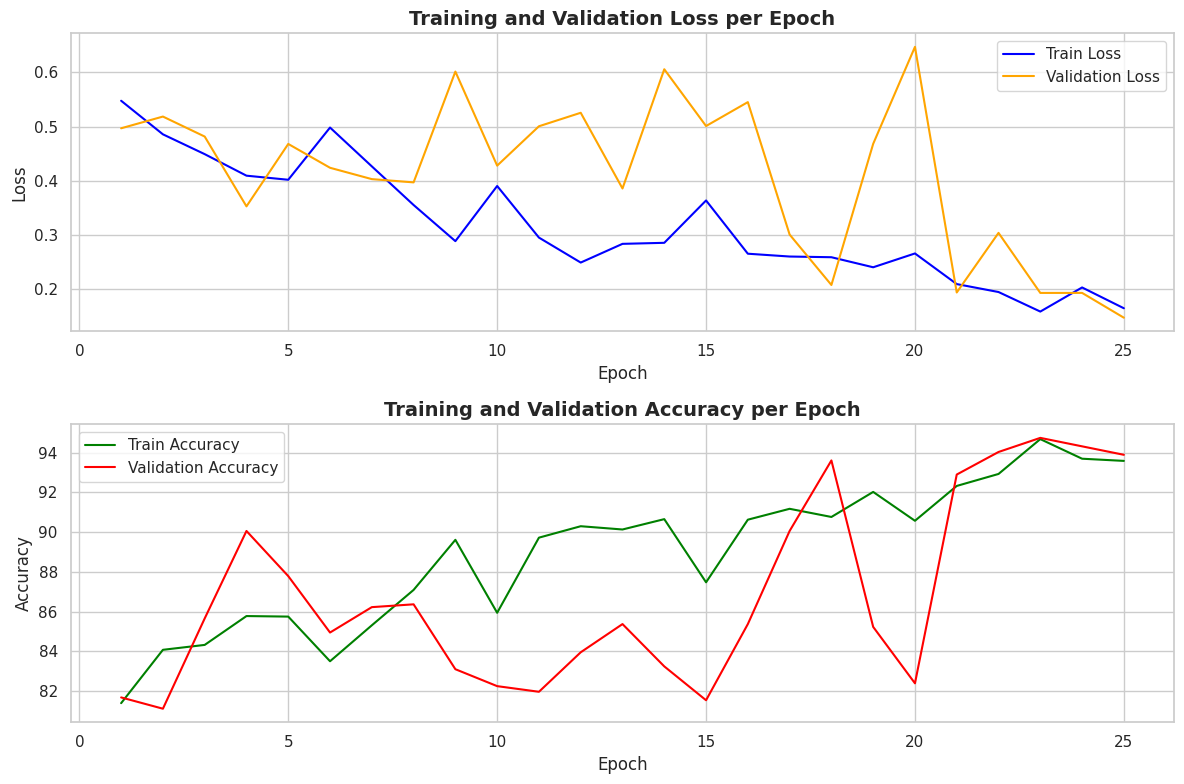

In [67]:
metrics_path = f"{MODEL_NAME}_metrics.csv"
metrics_df = pd.read_csv(MODEL_SAVE)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
sns.lineplot(x='epoch', y='train_loss', data=metrics_df, label='Train Loss', color='blue')
sns.lineplot(x='epoch', y='val_loss', data=metrics_df, label='Validation Loss', color='orange')
plt.title("Training and Validation Loss per Epoch", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.subplot(2, 1, 2)
sns.lineplot(x='epoch', y='train_accuracy', data=metrics_df, label='Train Accuracy', color='green')
sns.lineplot(x='epoch', y='val_accuracy', data=metrics_df, label='Validation Accuracy', color='red')
plt.title("Training and Validation Accuracy per Epoch", fontsize=14, fontweight='bold')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.tight_layout()
output_plot_path = f"{MODEL_NAME}_training_visualization.png"
plt.savefig(output_plot_path, dpi=300)
print(f"Visualization saved to {output_plot_path}")
plt.show()

In [68]:
print(os.getcwd())


/content


In [63]:
def load_model_from_checkpoint(checkpoint_path, model_class, device):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()
    return model

In [64]:
def predict_on_validation(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return np.array(y_true), np.array(y_pred)

In [69]:
checkpoint_path = "/content/vit_base_patch16_siglip_256_epoch_19.pt"
model_class=5
model = load_model_from_checkpoint(checkpoint_path, model_class, device)
y_true, y_pred = predict_on_validation(model, val_loader, device)

<ipython-input-63-5dfaa50159be>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=device))


In [70]:
report = classification_report(y_true, y_pred, digits=2)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99       351
           1       0.86      0.53      0.65        68
           2       0.84      0.67      0.75       181
           3       0.78      0.93      0.85        45
           4       0.48      1.00      0.65        59

    accuracy                           0.85       704
   macro avg       0.79      0.82      0.78       704
weighted avg       0.89      0.85      0.86       704



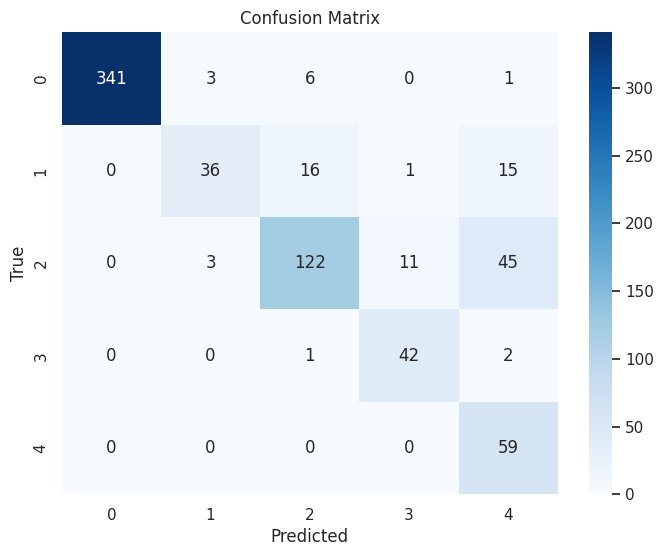

In [71]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.arange(cm.shape[0]), yticklabels=np.arange(cm.shape[0]))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_Swin 98.png', bbox_inches='tight')
plt.show()

In [72]:
level_to_category = {
    0: "No_DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}
class_errors = {}
num_classes = cm.shape[0]

for i in range(num_classes):
    total = np.sum(cm[i, :])
    incorrect = total - cm[i, i]
    error_rate = incorrect / total if total != 0 else 0
    class_errors[level_to_category[i]] = round(error_rate, 4)
for class_name, error_rate in class_errors.items():
    print(f"Class {class_name}: Error Rate = {error_rate}")


Class No_DR: Error Rate = 0.0285
Class Mild: Error Rate = 0.4706
Class Moderate: Error Rate = 0.326
Class Severe: Error Rate = 0.0667
Class Proliferate_DR: Error Rate = 0.0


In [73]:
error_data = pd.DataFrame(list(class_errors.items()), columns=['Class', 'Error Rate'])

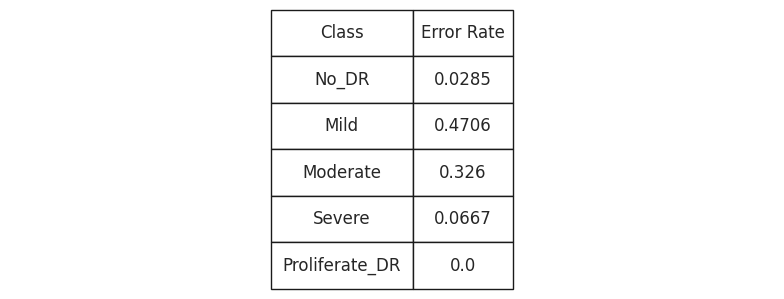

In [74]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.axis('off')
table = ax.table(cellText=error_data.values, colLabels=error_data.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(error_data.columns))))
table.scale(20, 5)
plt.savefig('Swin Table .png', bbox_inches='tight')

plt.tight_layout()
plt.show()

Predicted label: Severe


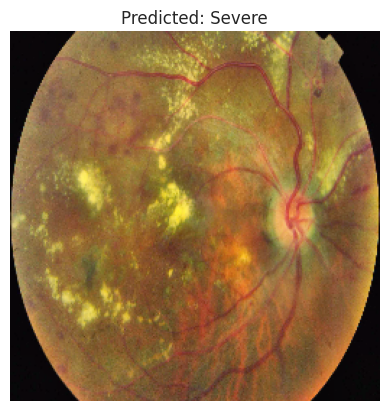

In [75]:
import torch
import cv2
import numpy as np
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt
train_transforms_DeiT_base_patch16 = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def process_external_image(image_path, transform=train_transforms_DeiT_base_patch16):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_cropped = crop_image_from_gray(image)
    image_resized = cv2.resize(image_cropped, (256, 256))
    blue, green, red = cv2.split(image_resized)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    blue_clahe = clahe.apply(blue)
    green_clahe = clahe.apply(green)
    red_clahe = clahe.apply(red)
    result_image = cv2.merge([blue_clahe, green_clahe, red_clahe])
    pil_image = Image.fromarray(result_image)
    image_tensor = transform(pil_image)
    image_tensor = image_tensor.unsqueeze(0)

    return image_tensor

def predict_on_external_image(model, image_tensor, device):
    model.eval()
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_label = torch.max(output, 1)

    return predicted_label.item()
image_path = "/content/drive/My Drive/aptos2019-blindness-detection/processed_images/0c917c372572.png"
image_tensor = process_external_image(image_path)
predicted_label = predict_on_external_image(model, image_tensor, device)

level_to_category = {
    0: "No_DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}

print(f"Predicted label: {level_to_category[predicted_label]}")

image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.title(f"Predicted: {level_to_category[predicted_label]}")
plt.axis('off')
plt.show()
